# Importaciones
Si usamos google Colab nefcesitamos instalar pytorch lighting. Lo demás son las importaciones necesarias

In [1]:
# conda install pytorch torchvision torchaudio pytorch-cuda=11.7 -c pytorch -c nvidia
# pip install torch-summary
# conda install -c conda-forge tensorboard
# conda install -c conda-forge matplotlib
# conda install pytorch-lightning -c conda-forge

# En caso de que usemos google colab
# !pip install pytorch-lightning

In [2]:
import os

import torch # torch solamente me imcluye las operaciones con tensores
import torchvision # me proporciona los datasets y transformaciones tipicas
import torch.nn as nn # es el que me permite la definicion de las redes y sus capas
import torch.optim as optim # es el que me permite definir el optimizador
import torch.nn.functional as F # me permite las operaciones de activación o de poolong
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchinfo import summary # me hace la representación to guapa de summary de keras
from torch.utils.data import DataLoader, random_split # Cargamos el dataloader y el random split, ya que son importantes
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl

from torch.utils.tensorboard import SummaryWriter # Para ejecutar posteriormente el tensorboard
writer = SummaryWriter('runs/MNIST')

# Establecemos una semilla de forma que siempre obtengamos los mismos conjuntos e imágenes. Esto es útil para poder observar los cambios que hacemos sobre la red.
#También para buscar la imagen que más nos interesa
random_seed = 4 # Probados: 1, 2, 3, 4, 5, 40, 41, 42       4 es el que hemos puesto en el TFM
torch.manual_seed(random_seed)

# Configuración GPU/CPU
Aquí definiremos la GPU que usaremos durante el entrenamiento y el número de nucleos del procesador, ya que todos los procesos que no requieren entrenamiento se llevan a cabo en la CPU

In [3]:
# Cogemos el mínimo porque si tengo más de una GPU hay que usar el modelo como data parallel
AVAIL_GPUS = min(1, torch.cuda.device_count())
print('Gráfica:', torch.cuda.get_device_name(torch.cuda.current_device()))

# Por qué workers y no cores? Porque pytorch lightning llama así a este dato en el dataloader. Dividimos entre 2 porque me cuenta los hilos
NUM_WORKERS = int(os.cpu_count() / 2)
print('Número de núcleos de la CPU:', NUM_WORKERS)

Gráfica: NVIDIA GeForce GTX 1660 Ti
Número de núcleos de la CPU: 6


# Mostramos algunos ejemplos

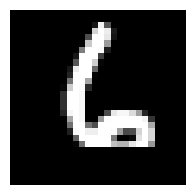

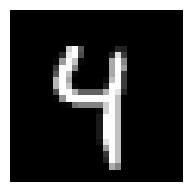

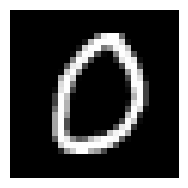

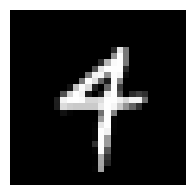

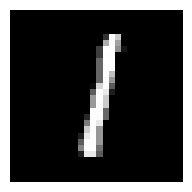

In [4]:
# Transforma el dataset a tensores
transform = transforms.ToTensor()

# Carga el conjunto de datos MNIST
mnist = MNIST('.', train=True, download=True, transform=transform)

# Obtiene la primera imagen del conjunto de datos
#image, label = mnist[0]

# Muestra la imagen utilizando matplotlib
#plt.imshow(image.squeeze(), cmap='gray')
#plt.axis('off')
#plt.show()
fig = plt.figure()
for i in range(5):
    image, label = mnist[i+14423]
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.axis('off')                
    plt.imshow(image.squeeze(), cmap='gray', interpolation = 'none')
                     
    plt.show()

# Carga y tratamiento del dataset
El DataModule es una clase que hereda de LightingDataModule y esencialmente es una clase en la que recopilamos todas las funciones de descarga y tratamiento del dataset, de forma que el código, si bien es esencialmente el mismo, queda mucho más organizado  
A lo largo del código también observaremos que Pytorch Lightinig posee ciertas funciones o métodos propios para realizar operaciones y que debemos incluir. Esto es cómodo porque nos ahorra hacerlo manualmente, pero es más complejo pues se ha de saber que existen y cómo se usan. Además, también favorece la reusabilidad y su uso en diferentes máquinas  
Como se puede ver en los comentarios inferiores, el `prepare_data` realmente no sería necesario y se podría hacer directamente en el `setup` poniendo `download = True`. Sin embargo, interesa separarlo precisamente por lo que dice el comentario, que el `prepare_data` se ejecuta en un sólo núcleo asegurando así una correcta descarga del dataset

In [5]:
# Definimos el tamaño de lote
BATCH_SIZE = 128

class MNISTDataModule(pl.LightningDataModule):
    # El init es nuestro constructor. Como tenemos que crear variables, llamaremos a la función con éstas para que nos cree los correspondientes objetos pertenecientes a esa clase
    def __init__(self, data_dir = "./data", batch_size = BATCH_SIZE, num_workers = NUM_WORKERS):
        super().__init__()
        
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        
        # Intuitivamente no tiene mucho sentido un objeto que actúe como método, pero el método setup requiere esta entrada si queremos realizar transformaciones, así que lo hacemos así
        # Ahora tenemos que crear una transformación que modifique las imágenes: ToTensor: Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
        # Además, las normalizamos empleando la media y la desviación estándar. Lo que hace es imagen = (imagen-media)/std, de forma que conseguimos que la media sea 0 y la std 1, como una distribución normal. Esto supuestamente ayuda un poco a la red pues reduce la asimetría y es una práctica común
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)),])
     
    # El prepare_data se asegura de descargar el dataset sólo en la primera ejecución, luego lo detectará en el directorio. Además, también emplea un sólo núcleo del procesador, 
    # ya que más puede resultar en datos corruptos
    def prepare_data(self):
        MNIST(self.data_dir, train = True, download = True) # Para el entrenamiento
        MNIST(self.data_dir, train = False, download = True) # Para el test
        return type(MNIST)
        
    # Aquí separamos el dataset en entrenamiento, validacion y test, además de forma aleatoria, e y aplicando la transformacion anteiror. El setup, además, ya nos realiza las 
    # operaciones en la GPU. Setup espera siempre un argumento stage para separar las instancias
    def setup(self, stage = None):
        if (stage == "fit" or stage is None):
            mnist_full = MNIST(self.data_dir, train = True, transform = self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])
            
        if (stage == "test" or stage is None):
            self.mnist_test = MNIST(self.data_dir, train = False, transform = self.transform)
    
    # Finalmente, definimos los dataloaders. El método fit es el que llamará a estas tres funciones para cargar los datos del dataset
    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size = self.batch_size, num_workers = self.num_workers)
    
    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size = self.batch_size, num_workers = self.num_workers)
    
    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size = self.batch_size, num_workers = self.num_workers)    

# Discriminador
- Recodemos que el discriminador es como el detective de la red y nos dirá si una imagen es real o no, de forma que la fucnión de activación de la última capa será siempre una sigmoide (1, 0). Es decir, se trata de un clasificador  
- En keras recordemos que funcionaba de una forma que me resulta más intuitiva: `model.add (layers.conv2D (32, (3,3), activation = relu, input_shape = (32, 32, 1))` es decir, directamente en la propia definición deciímos el tamaño del mapa de características, el kernel, la activación y el tamaño de la entrada  
- En pytorch, sin embargo, dividimos el proceso en 2. Primero definimos las capas en sí mismas, sin que sea necesario especificar el tamaño de la imagen de entrada. Posteriormente, en la función `forward` será en la que realicemos las operaciones sobre cada una de las imágenes del set, es decir, las activaciones, flatten y pools

In [6]:
class Discriminator(nn.Module):
    # Definimos el constructor. Como no vamos a introducir los parámetros, no hay que poner nada dentro de los paréntesis, simplemente definir la red
    def __init__(self):
        super().__init__() # dentro de esta funcion, además, es donde definitiamos los paddings, bias.... pero tiene valores predefinidos de todo y no vamos a cambiarlos
        # OJO! Aquí tenemos que definir las capas de la red, pero no aplicar las operaciones!
        # Comenzamos con dos capas convolucionales. Definimos la entrada, que será una imagen (que es en blanco y negro, de forma que solamente tiene un canal) 
        # y la salida que será un mapa de caracteristicas de profundidad 10, es decir, empleamos 10 kernels distintos de tamaño 5x5
        # Nótese que no especificamos el tamano de la entrada!!!
        self.conv1 = nn.Conv2d(1, 10, kernel_size = 5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)
        
        # El dropout lo que hace es drop out o eliminar ciertas neuronas de la red en la capa en la que estamos, de forma que estamos entrenando simultáneamente distintos tipos de arquitecturas. 
        # El dropout reduce el overfitting significativamente, si bien requiere de más tiempo de entrenamiento. Es decir, mejora la generalización
        self.conv2_drop = nn.Dropout2d() # La probabilida de que una neurona se desactive es 0.5% por defecto
        
        # Y finalmente pasamos a las capas lineales, que recordemos que siempre va na ser necesarias por que el proceso de adquisición de datos ha terminado y pasamos a un proceso de clasificación
        # para lo cual necesitamos las capas lineales. El flateen se realiza en el forward
        # la última capa siempre será de una sola neurona puesto que la salida será si la imagen es real o no
        # Por qué 320? Efectivamente, después de las conv y los pools la salida es de 4x4x20, es decir, 320 parámetros (recordemos que MNIST 1x28x28)
        # Lo suyo sería calcularlo dentro del propio código, pero bueno, yo lo he calculado externamente
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50,1)
        
    # En el forward, sin embargo, es donde sí definimos las operaciones, es decir, los poolings y las activaciones    
    def forward(self, x):
        # aqui por ejemplo se ve que primero aplicamos la convolucion, luego el pool y luego el relu y vamos sobreescribiendo la entrada
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        
        # Aplanamos el vector
        x = x.view(-1, 320)
        
        # Pasamos a las capas lineales
        x = F.relu(self.fc1(x))
        # Ahora hacemos otro dropout en la capas lineales, pero al método de F tenemos que especificar que sea sólo durante el entrenamiento, si no, lo mantendrá en el test y predicciones
        x = F.dropout(x, training = self.training)
        x = self.fc2(x)
        
        return torch.sigmoid(x)     

# Si queremos ver un resumen de la red en modo keras
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
discriminator = Discriminator().to(device)
summary(discriminator, (1, 28, 28))

C:\Users\pedro\anaconda3\envs\Pytorch\lib\site-packages\torch\nn\functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    --
├─Conv2d: 1-1                            [10, 24, 24]              260
├─Conv2d: 1-2                            [20, 8, 8]                5,020
├─Dropout2d: 1-3                         [20, 8, 8]                --
├─Linear: 1-4                            [1, 50]                   16,050
├─Linear: 1-5                            [1, 1]                    51
Total params: 21,381
Trainable params: 21,381
Non-trainable params: 0
Total mult-adds (M): 0.88
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.09
Estimated Total Size (MB): 0.15

# Generador
The generator model is responsible for creating new, fake but plausible images of handwritten
digits. It does this by taking a point from the latent space as input and outputting a square
grayscale image. <b>The latent space is an arbitrarily defined vector space of Gaussian-distributed
values, e.g. 100 dimensions.</b> It has no meaning, but by drawing points from this space randomly
and providing them to the generator model during training, the generator model will assign
meaning to the latent points. At the end of training, the latent vector space represents a
compressed representation of the output space, MNIST images, that only the generator knows
how to turn into plausible MNIST images.  

We don’t have to use a 100 element vector as input; it is a round number and widely used,
but I would expect that 10, 50, or 500 would work just as well. Developing a generator model
requires that we transform a vector from the latent space with, 100 dimensions to a 2D array
with 28×28 or 784 values. There are a number of ways to achieve this but there is one approach
that has proven effective at deep convolutional generative adversarial networks. It involves two
main elements. The first is a Dense layer as the first hidden layer that has enough nodes to
represent a low-resolution version of the output image. Specifically, an image half the size (one
quarter the area) of the output image would be 14 × 14 or 196 nodes, and an image one quarter
the size (one eighth the area) would be 7 × 7 or 49 nodes. 

We don’t just want one low-resolution version of the image; we want many parallel versions
or interpretations of the input. This is a pattern in convolutional neural networks where we
have many parallel filters resulting in multiple parallel activation maps, called feature maps,
with different interpretations of the input. We want the same thing in reverse: many parallel
versions of our output with different learned features that can be collapsed in the output layer
into a final image. The model needs space to invent, create, or generate. Therefore, the first
hidden layer, the Dense layer needs enough nodes for multiple low-resolution versions of our
output image, such as 128.

Mirar libro página 106 para más información

<b> El latent_dim es necesario como dato de entrada al constructor del generador porque necesitamos definir la red en función del número de datos que queramos como entrada, por si queremos cambiarlo. Si lo fijamos a 100, no cambia nada </b>

In [7]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        # Comenzamos a definir las capas. Como se menciona en el párrafo anteior, comenzamos con una capa densa cuya salida debe ser una imagen 
        # en baja resolución de la imagen de salida, en este caso 1/4. Además, similar a los mapas de características, definimos, en este caso 64, digamos
        # kernels, es decir, 64 imagenes de 7x7. Diferentes representaciones
        self.lin1 = nn.Linear(latent_dim, 7*7*64)
        
        # Ahora tenemos que transformar ese vector anterior en algo con forma de imagen, "matriciarlo" lo contrario a flatten. Esto se hace en el forward. 
        # Ahora tendríamos que realizar la inversa de un pooling, es decir, un upsampling2d, seguido de una capa de convolución. Sin embaergo, la operación que lo une es una convolución transpuesta
        # Aquí simplemente con especificar que la entrada es 64 (el ¨mapa¨ anteior) y la salida 32 es suficiente. El stride de 2 nos asegura que doblamos el tamaño
        # de la imagen y el kernel tiene que ser un múltiplo, en este caso, 4, si no, nos quedaría una imagen con un patrón de ajedrez
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride = 2)
        
        # Repetimos lo mismo
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride = 2) # Aquí la salida es de 34x34x16
        
        # Y finalmente, realizamos una convolución simple para reducir el mapa de características anterior al tamaño deseado
        self.conv = nn.Conv2d(16, 1, kernel_size = 7)
        
    def forward(self, x):
    
        x = self.lin1(x)
        x = F.relu(x)
        
        # Reescribimos el vector resultante para que tenga forma de un mapa de caraceristcas de 7x7 y 64 caracteristicas
        x = x.view(-1, 64, 7, 7)
        
        # Aplicamos la primera capa convolucional transpuesta sin más
        x = self.ct1(x)
        x = F.relu(x)
        
        # Aplicamos la segunda capa sin más
        x = self.ct2(x)
        x = F.relu(x)
        
        # y finalmente devolvemos el resultado de la ultima capa que es la convolucional normal. OJO! Sin activación!!!!
        return self.conv(x)
    
# Si queremos ver un resumen de la red en modo keras
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
generator = Generator(100).to(device)
summary(generator, (1, 100))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 1, 28, 28]            --
├─Linear: 1-1                            [1, 3136]                 316,736
├─ConvTranspose2d: 1-2                   [1, 32, 16, 16]           32,800
├─ConvTranspose2d: 1-3                   [1, 16, 34, 34]           8,208
├─Conv2d: 1-4                            [1, 1, 28, 28]            785
Total params: 358,529
Trainable params: 358,529
Non-trainable params: 0
Total mult-adds (M): 18.82
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 1.43
Estimated Total Size (MB): 1.68

# Unión
Tenemos tres funciones que deben definirse con los siguientes nombres: training_step, configure_optimizers y on_epoch_end, ya que se trata de funciones a las que llama python sí o sí cuando definimos el modelo

In [8]:
discriminator_loss = []

class GAN(pl.LightningModule):
    def __init__(self, latent_dim, lr):
        super().__init__()
        
        # Save_hyperparameters lo que hace es guardar las variables con las que construimos la clase que hereda de LightningModule
        # Esto es útil por dos motivos: los guarda para acceder a ellos y porque los guarda en los checkpoints, de forma que se cargarían si paramos y seguimos el entrenamiento
        # Pero dentro del propio constructor, esas variables sí existen y, por tanto, las podemos llamar directamente. Despuiés sí usaremos los hiperparámetros. Si no, las entradas deberían ser variabloes globales
        self.save_hyperparameters()
        
        # Definimos un objeto con cada red
        self.generator = Generator(latent_dim) # Aquí definía latent_dim = hpparams....
        self.discriminator = Discriminator()
        
        # Creamos 6 entradas de forma de dimensión latente que usaremos después como validación
        self.validation_z = torch.randn(6, latent_dim)
    
    # Esta función como tal es innecesaria, podemos poner solo el generator.forward. Sim embargo, es obligatoria
    # Además, cuando llamemos una red no es necesario poner el forward. La red, una vez definida llama a la función forward automáticamente al poner generator(z). Sin embargo, lo especifico por claridad
    def forward(self, z): # NECESARIA
        return self.generator.forward(z)
    
    # Metemos el error dentro de una función porque si queremos cambiarlo sólo tenemos que cambiar esta línea
    # Recordemos que y_hat es la predicción e y la real
    def adversarial_loss(self, y_hat, y): # OPCIONAL PERO RECOMENDABLE
        return F.binary_cross_entropy(y_hat, y)
    
    # Ojo, tenemos dos redes, de forma que tenemos dos optimizadores, si bien ambos son el mismo
    def configure_optimizers(self): # NECESARIO
        # Creamos dos oprimizadores
        opt_g = torch.optim.Adam(self.generator.parameters(), lr = self.hparams.lr)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr = self.hparams.lr)
        return [opt_g, opt_d], []
    
    # Los datos de entrada están predefinidos. Además, como tenemos dos optimizadores, se define una entrada optimizer idx
    # Ojo, se va a llamar a esta función en cada batch!
    def training_step(self, batch, batch_idx, optimizer_idx): # NECESARIO
        # Nos quedamos sólo con las 128 imágenes del lote, porque no necesitamos las etiquetas. Aquí nos da igual lo que sea el número, sólo necesitamos saber si la imagen es falsa o verdadera, 1 ó 0
        real_imgs, _ = batch
        
        # Creamos el ruido inicial, que es el número de imágenes del batch -> real_imgs tiene forma (128,1,28,28), y la dimensión latente
        # Es decir, aquí estamos creando 128 vectores del tamaño de la dimensión latente, 100 elementos y los metemos en la gpu
        z = torch.randn(real_imgs.shape[0], self.hparams.latent_dim)
        z = z.type_as(real_imgs)
        
        # En el index 0 se entrena un optimizador (generador) y en el 1 el otro (discriminador). Esto es así en Lightning
        # train generator: max log(D(G(z)))
        if optimizer_idx == 0:
            # Creamos las imágenes falsas
            fake_imgs = self.forward(z) # Aquí con poner self(z) es suficiente, porque GAN ha sido definida, de forma que self(z) llama automáticamente a su forward, que llama a generador, que hace exactamente lo mismo. De todas formas, lo especifico por claridad
            # Y las clasificamos
            y_hat = self.discriminator.forward(fake_imgs)
            
            # Creamos un vector de tantos unos como el tamaño del lote y lo pasamos a la gpu. Es decir, creamos la etquetas del lote, que será 1 si son reales
            y = torch.ones(real_imgs.size(0), 1)
            y = y.type_as(real_imgs)
            
            # Calculamos la pérdida entre la salida del discriminador y nuestro vector de etiquetas que acabamos de calcular. Lógicamente, la  salida del discriminador es 1 si considera a la imagen como real
            # Es decir, si el discriminador considera que la imagen es real, 1, la pérdida del GENERADOR es 0
            g_loss = self.adversarial_loss(y_hat, y)
            
            # Añadimos el dato en el vector para imprimir posteriormente
            generator_loss[self.current_epoch] = g_loss
            
            # Almacenamos los resultados
            log_dict = {'g_loss': g_loss}
            return {'loss': g_loss, 'progress bar': log_dict, 'log': log_dict}
        
        # train discriminator max log (D(x) + log(1-D(G(z)))
        # Aquí queremos dos cosas. Queremos la pérdida cuando clasifica imágenes reales y cuando clasifica imágenes falsas
        if optimizer_idx == 1:        
            # Para las imágenes reales
            y_hat_real = self.discriminator.forward(real_imgs)
            
            # Creamos las etiquetas, que como son todas reales son 1
            y_real = torch.ones(real_imgs.size(0), 1)
            y_real = y_real.type_as(real_imgs)
            
            # Y calculamos la pérdida
            real_loss = self.adversarial_loss(y_hat_real, y_real)
            
            # Ahora pasasmos a las imágenes falsas
            # Conseguimos las etiquetas de un conjunto falso. Empleamos el detach porque no queremos que el generador me modifique su gradiente, simplemente clasificar las imágenes que obtiene
            y_hat_fake = self.discriminator.forward(self.forward(z).detach())
            
            # Creamos las etiquetas de las imágenes falsas, que lógicamente la etiqueta es 0
            y_fake = torch.zeros(real_imgs.size(0), 1) 
            y_fake = y_fake.type_as(real_imgs)
            
            # Calculamos la pérdida de las falsas
            fake_loss = self.adversarial_loss(y_hat_fake, y_fake)
            
            # Finalmente, hacemos la media entre las verdaderas y las falsas
            d_loss = (real_loss + fake_loss) / 2
            
            # Añadimos el dato en el vector para imprimir posteriormente
            falso_loss[self.current_epoch] = fake_loss
            verdadero_loss[self.current_epoch] = real_loss
            discriminator_loss[self.current_epoch] = d_loss
            
            # Almacenamos los resultados. Pytorch nos obliga a devolver diccionarios con los parámetros que queramos
            # pero tenemos que meter obligatoriamente la pérdida 
            log_dict = {'d_loss': d_loss}
            return {'loss': d_loss, 'progress bar': log_dict, 'log': log_dict}
        
    # Inicialmente puse on_epoch_end, pero ahora puedes definir qué proceso del epoch end concretamente
    def on_train_epoch_end(self): # OPCIONAL  
        self.plot_imgs()
    
    def plot_imgs(self, input = False):
        # Cogemos la imagen inicial, pero antes la pasamos a la gpu
        z = self.validation_z.type_as(self.generator.lin1.weight)
        # Esta linea lo que hace es ejecutar el generador y las ponemos de nuevo en la cpu
        sample_imgs = self.forward(z).cpu()
        
        fig = plt.figure()
        
        for i in range(sample_imgs.size(0)):
            # Hacemos un plot de 2x3
            # El tight layout asegura que los ejes de las imagenes no se juntan o se salen del espacio de la imagen
            # Quitamos los ejes por limpieza
            # El suptitle es un titulo general del subplot, ya que title me lo pone en cada imagen. Ademas, solo acepta un 1 argumento, de forma que tenemos que concatenar texto
            # Además, escribe un título u otro en función de si queremos el ruido o la salida de cada época
            plt.subplot(2, 3, i+1)
            plt.tight_layout()
            plt.axis('off')                
            plt.suptitle('Input noise') if input else plt.suptitle('Epoch ' + str(self.current_epoch + 1))
            
            # Definimos la imagen y la mostramos
            plt.imshow(sample_imgs.detach()[i, 0, :, :], cmap='gray', interpolation = 'none')          
        plt.show()

# Entrenamiento
Ya tenemos definidas todas las funciones necesarias. Ya solo tenemos que llamarlas para ejecutar el codigo

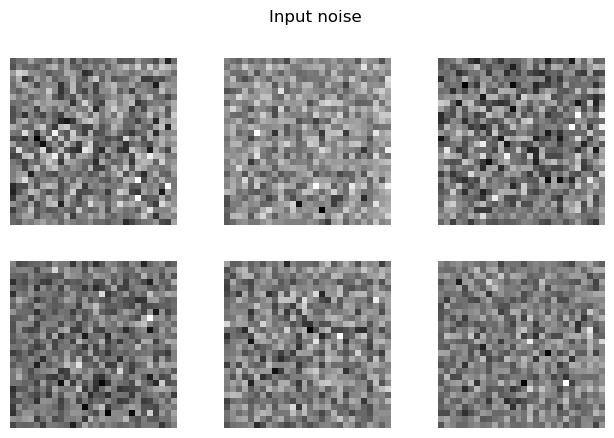

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\pedro\anaconda3\envs\Pytorch\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:105: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 358 K 
1 | discriminator | Discriminator | 21.4 K
------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

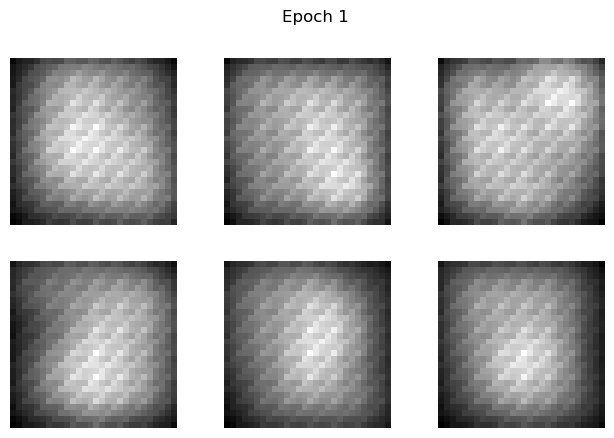

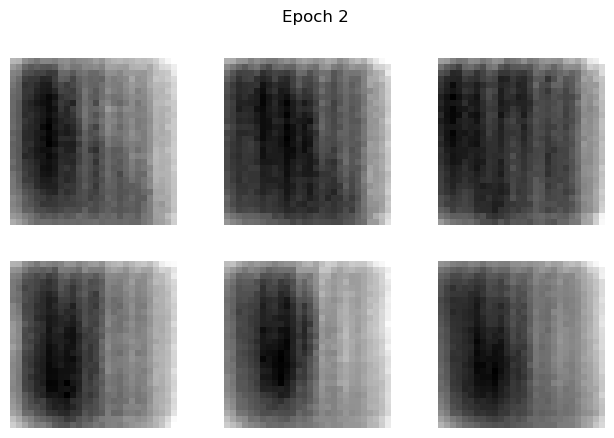

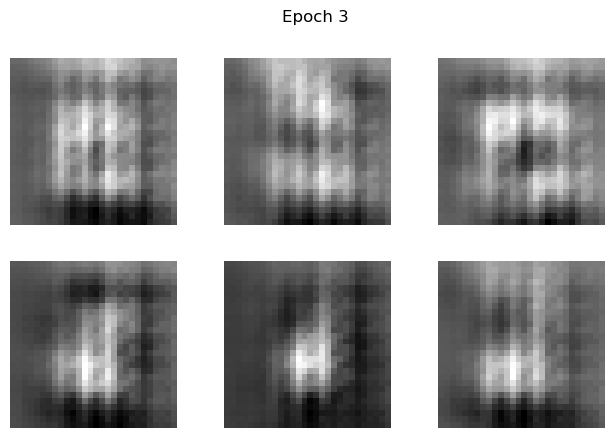

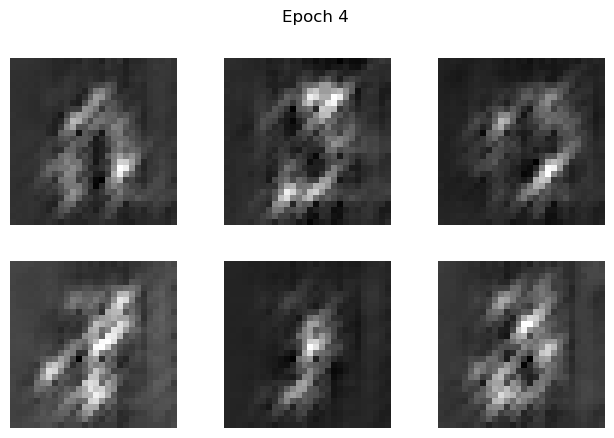

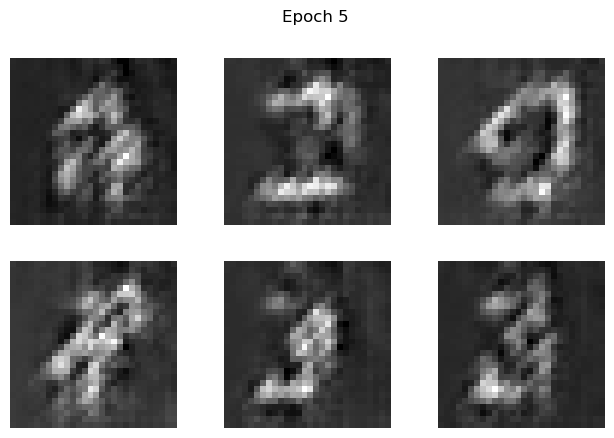

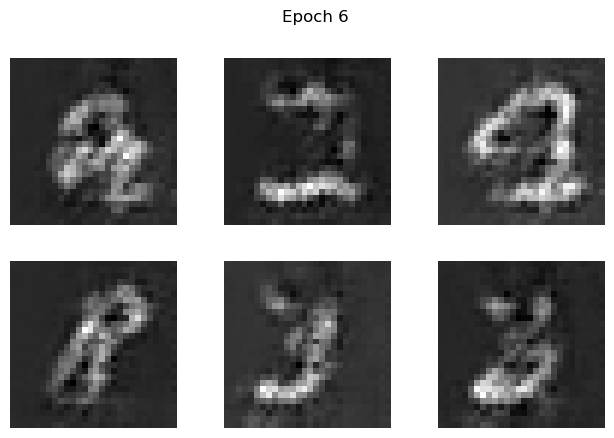

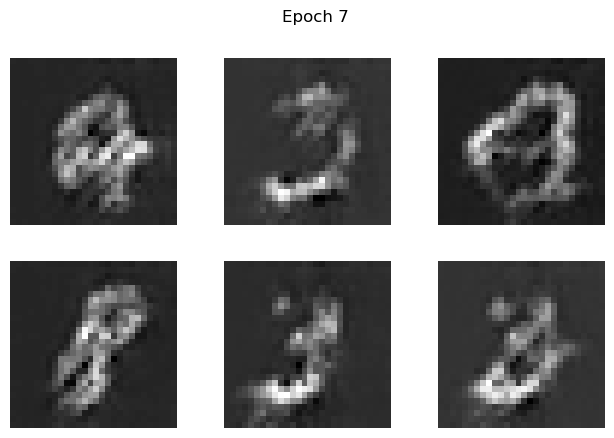

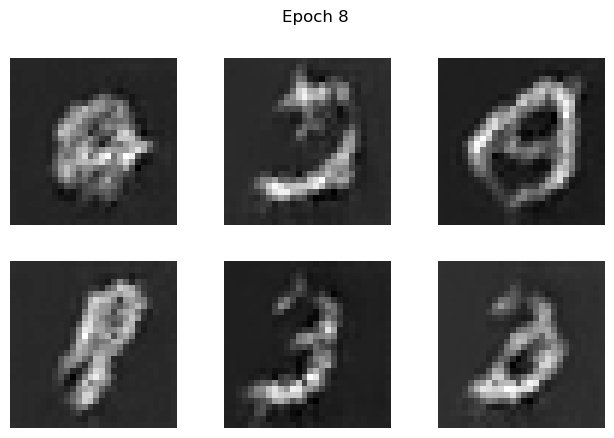

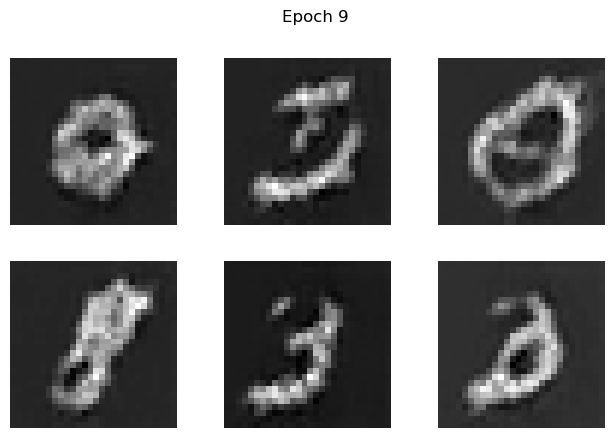

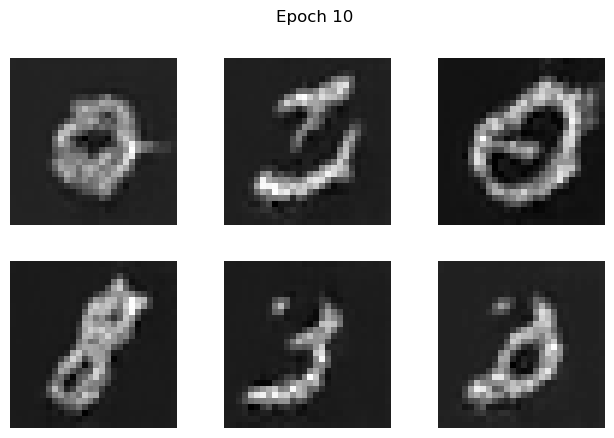

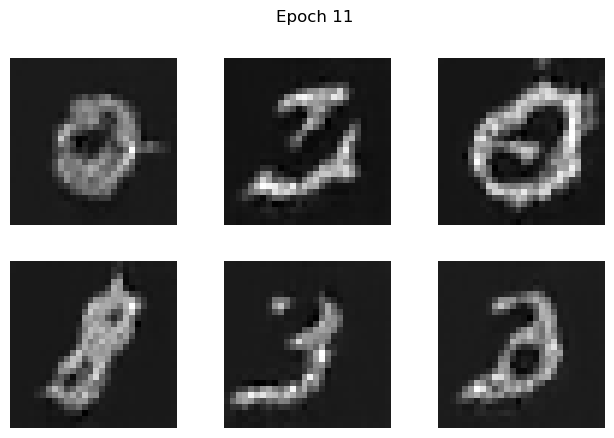

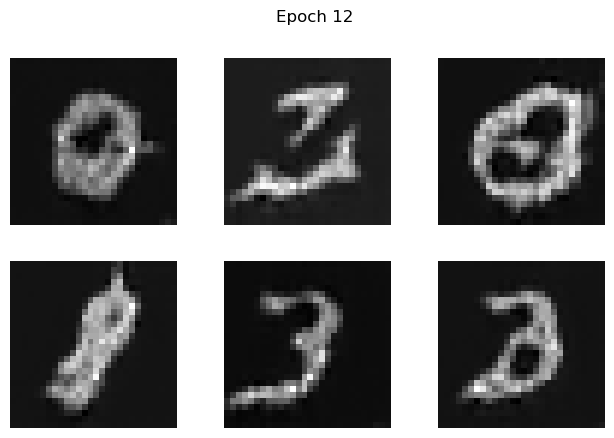

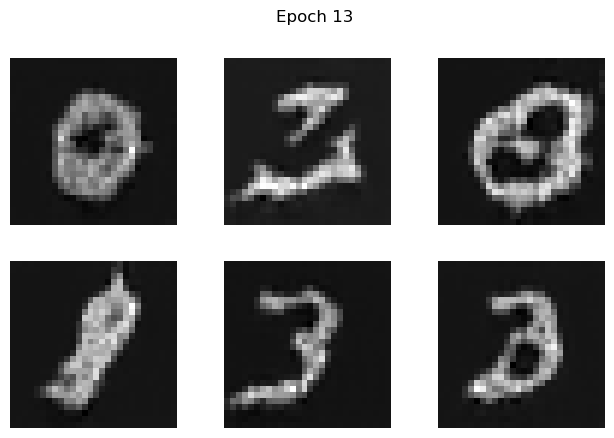

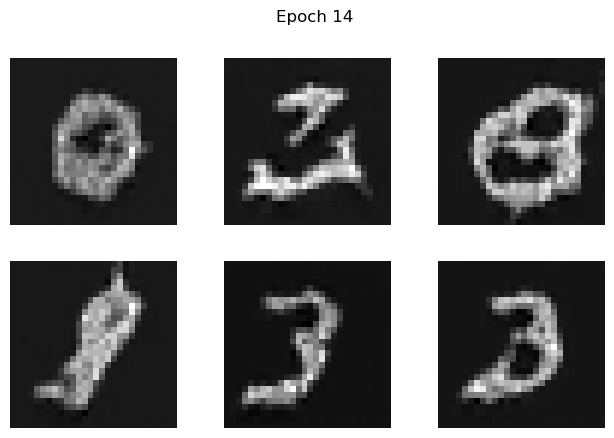

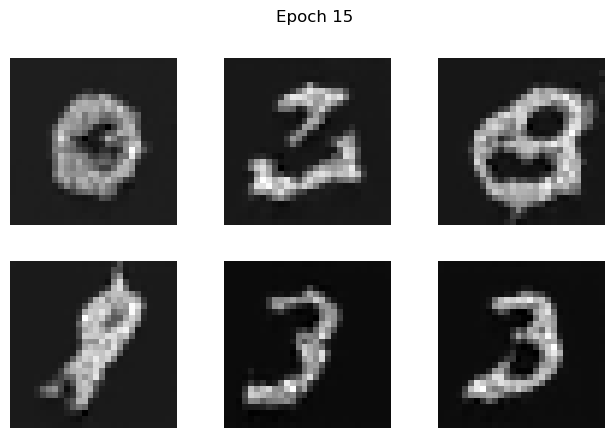

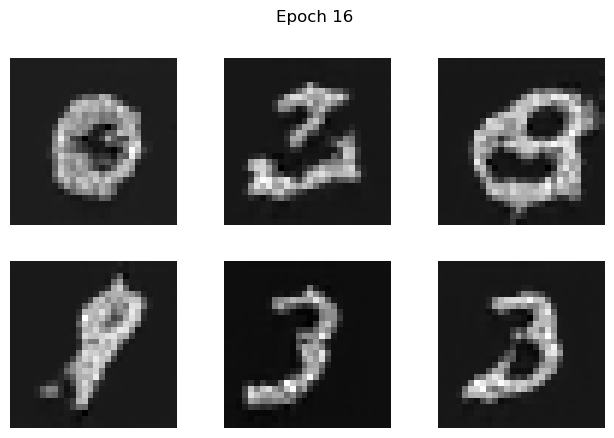

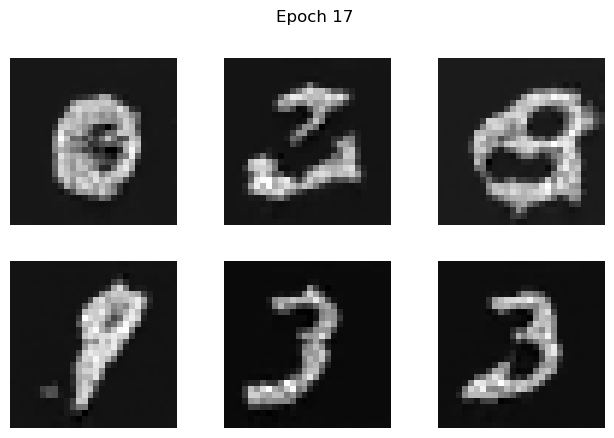

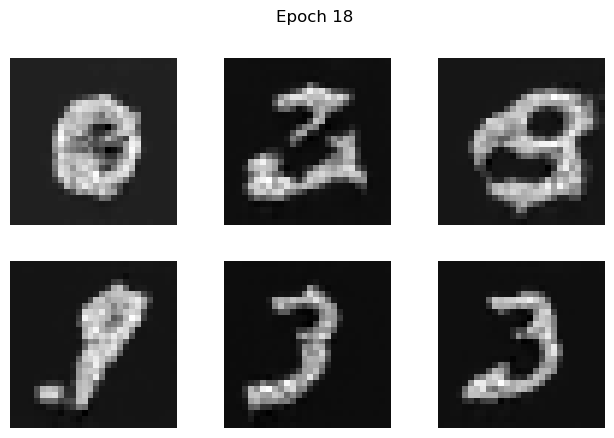

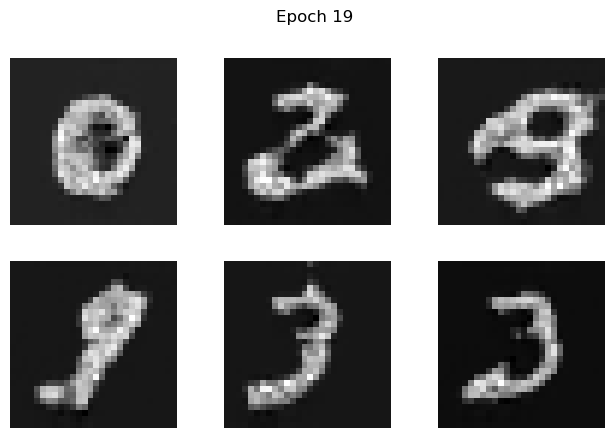

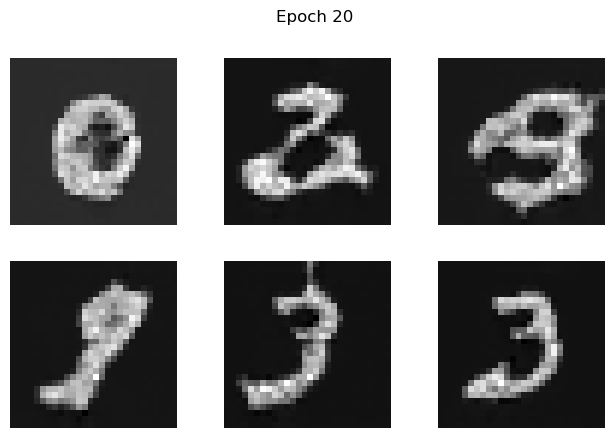

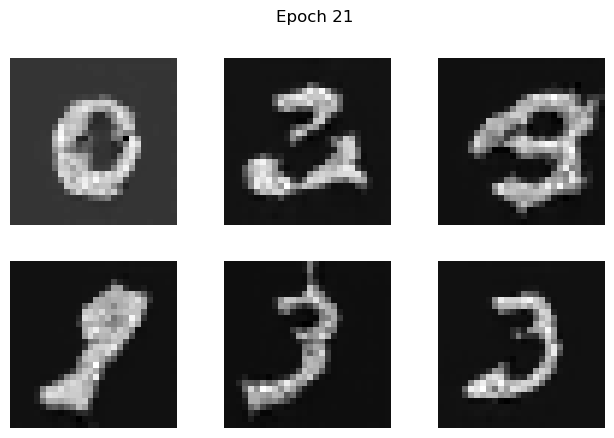

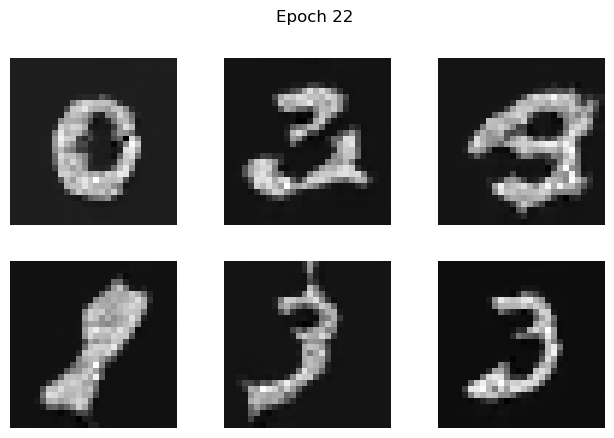

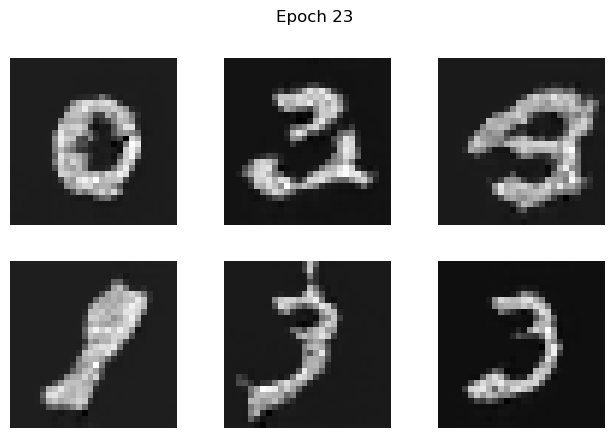

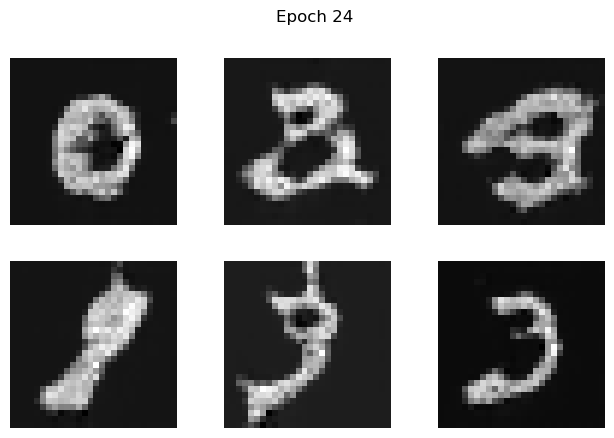

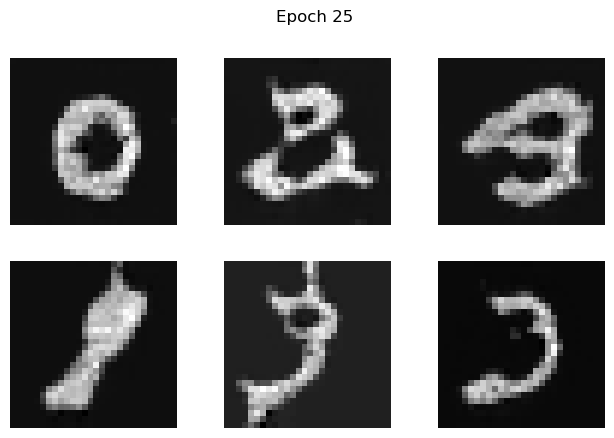

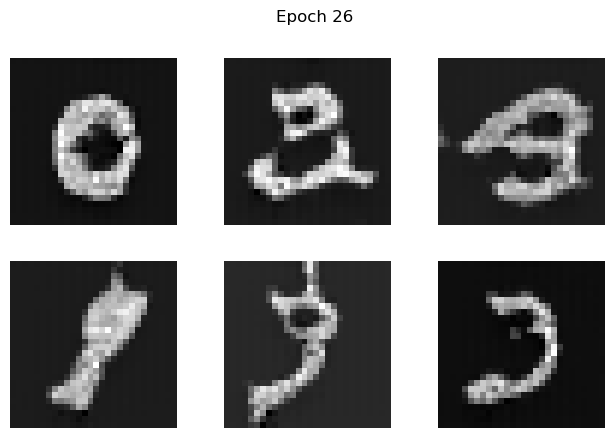

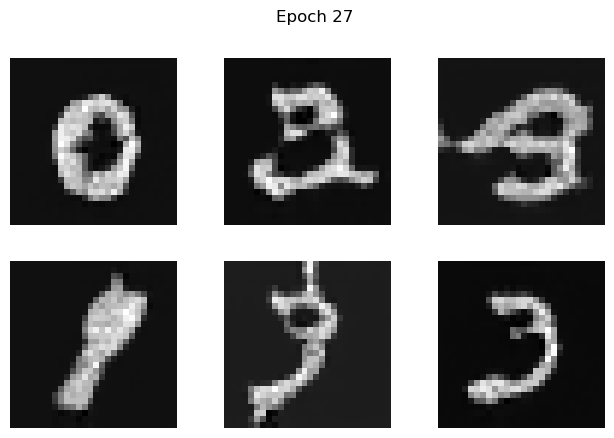

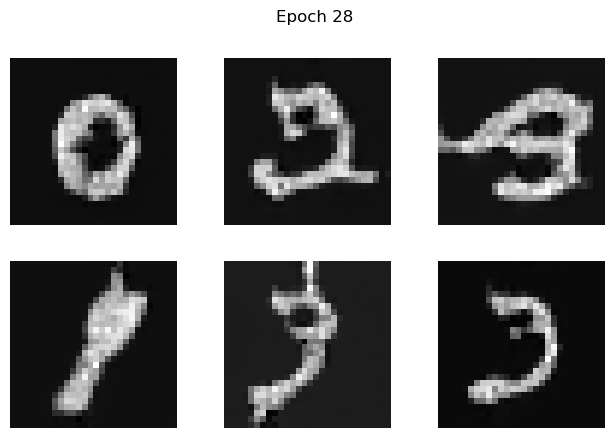

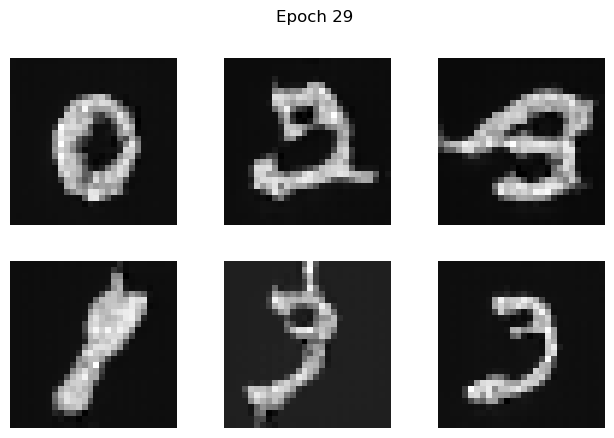

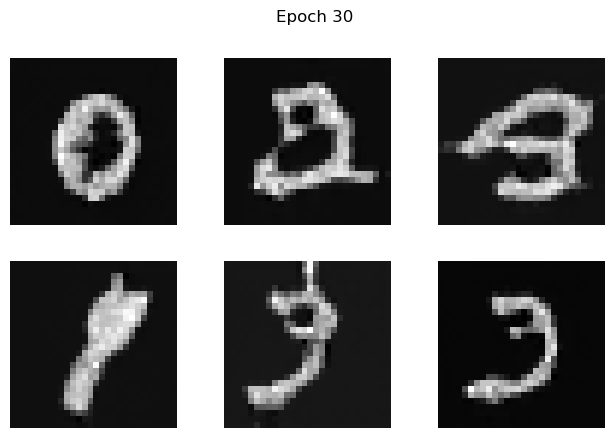

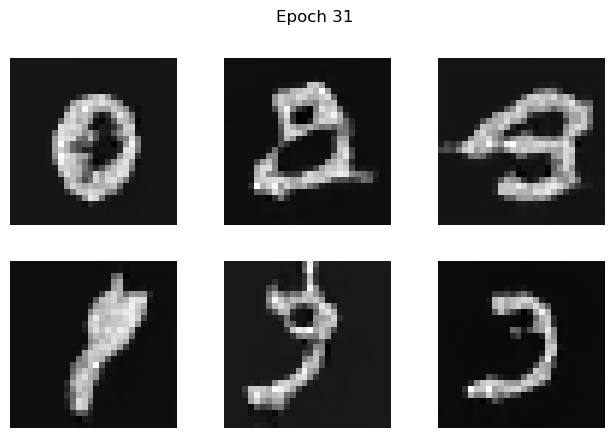

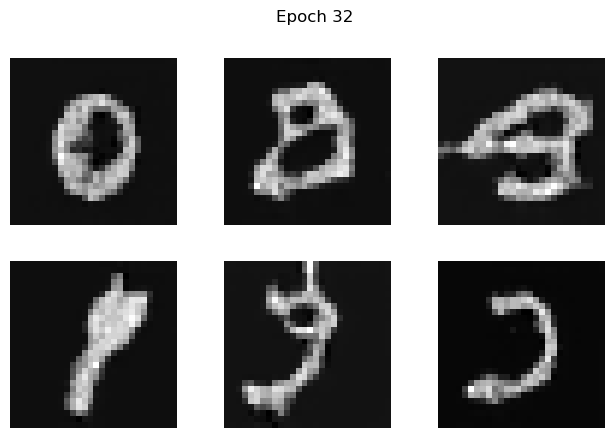

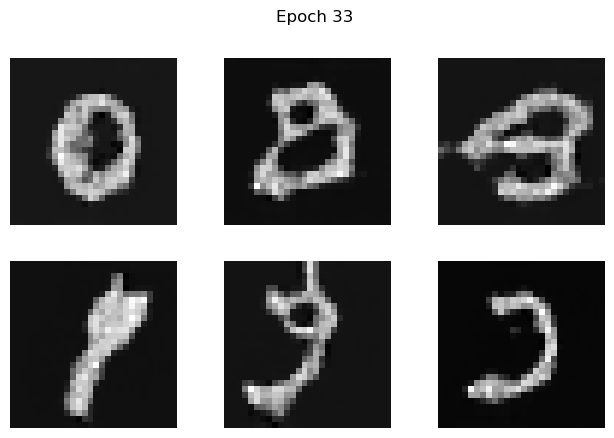

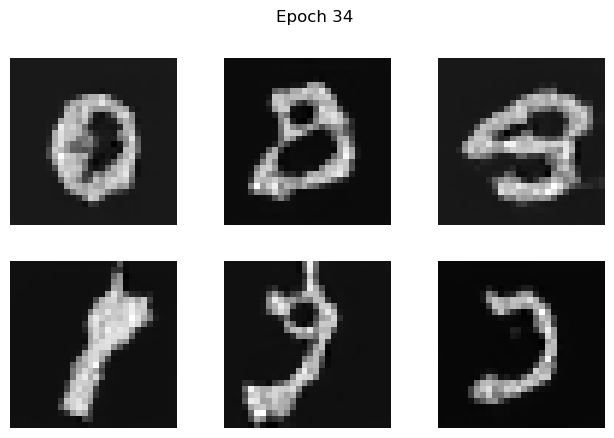

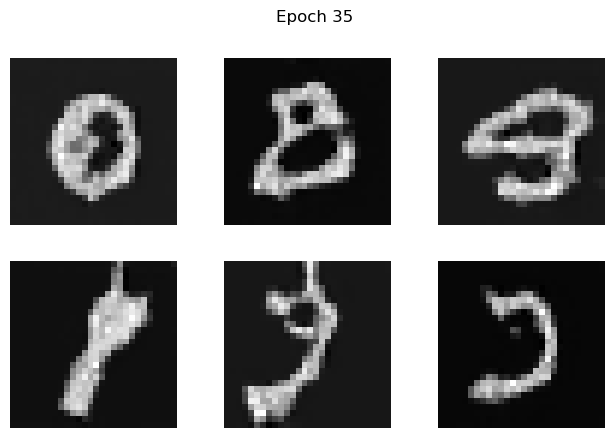

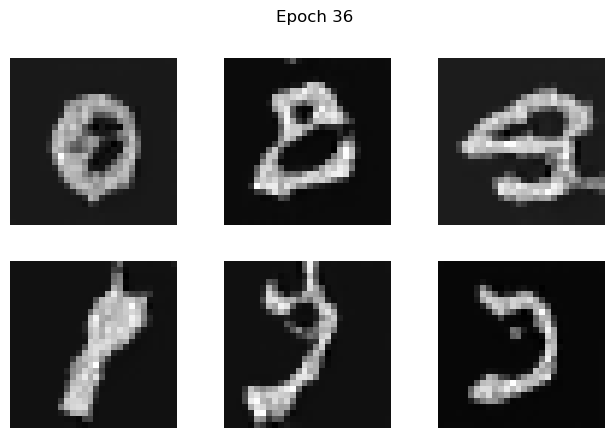

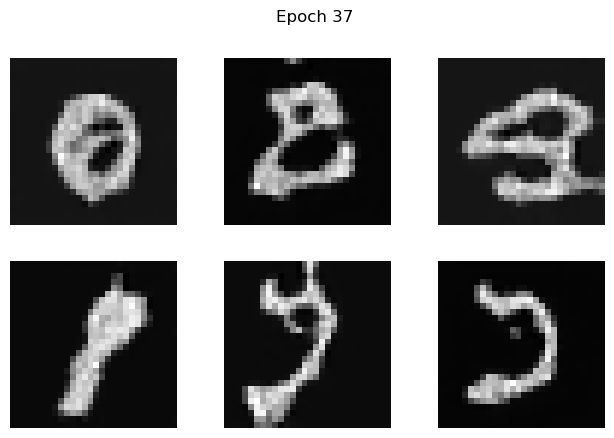

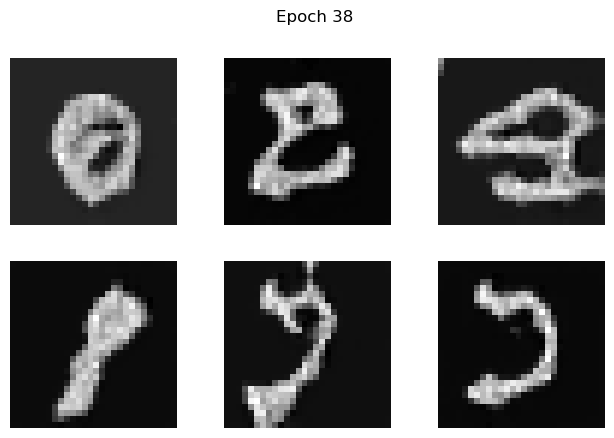

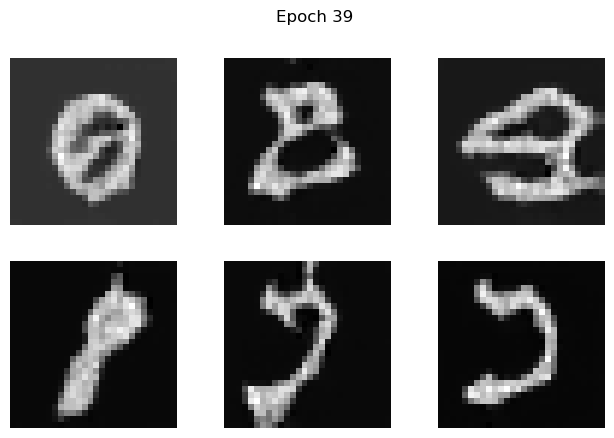

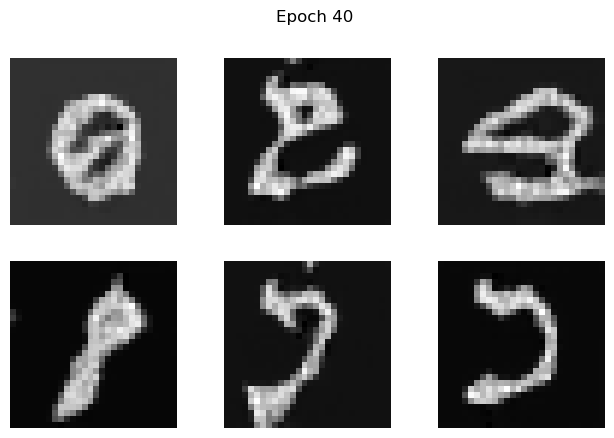

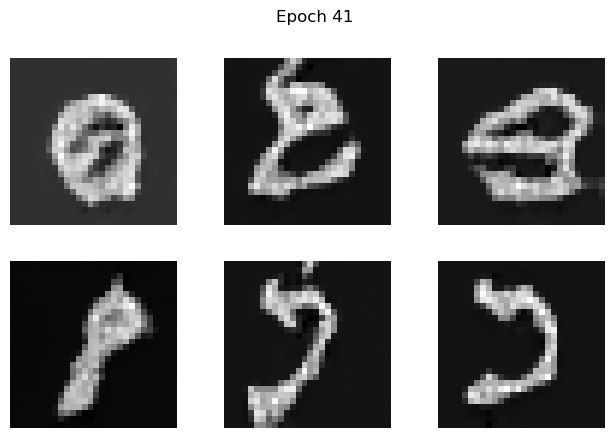

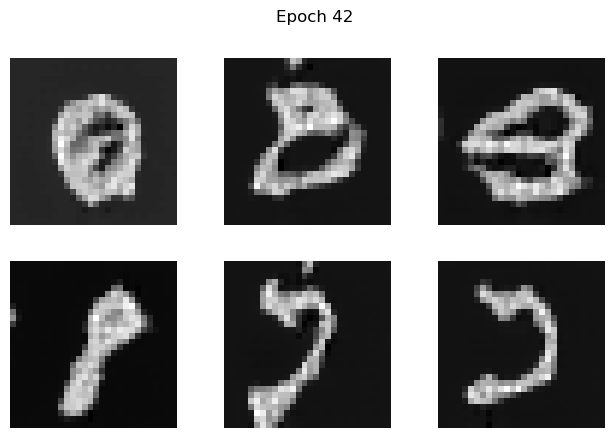

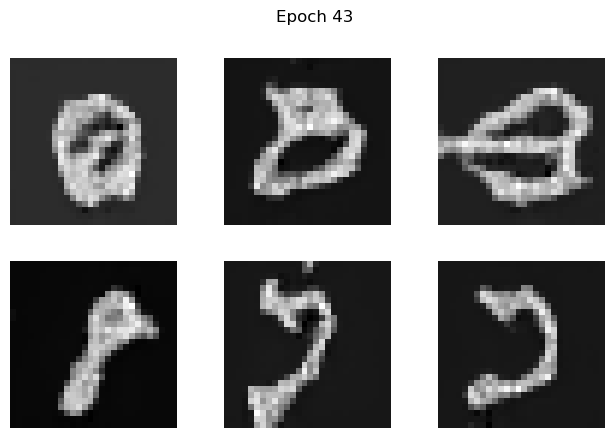

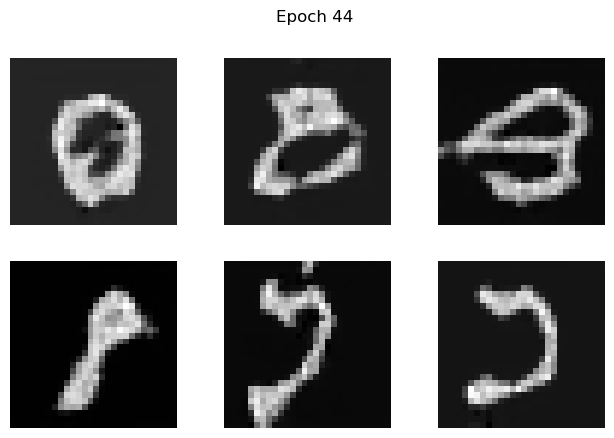

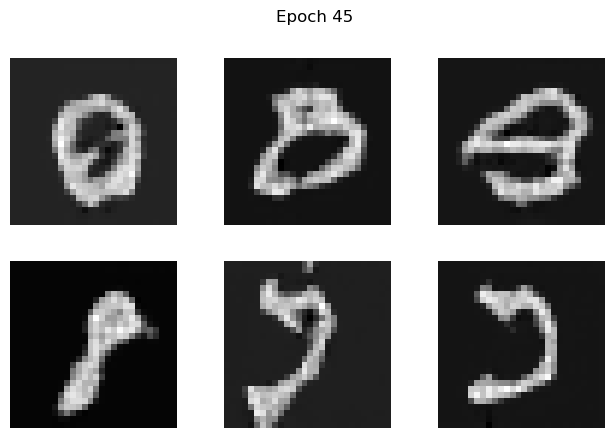

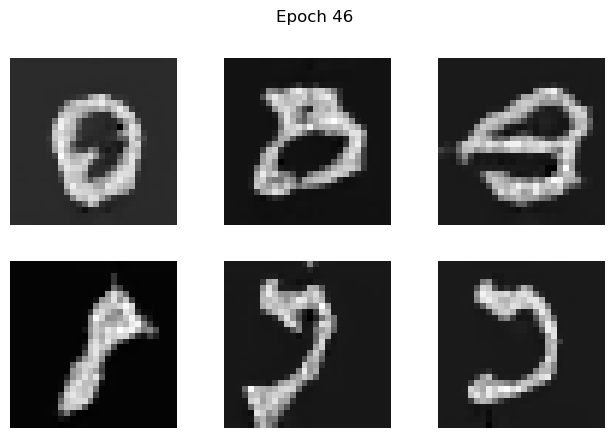

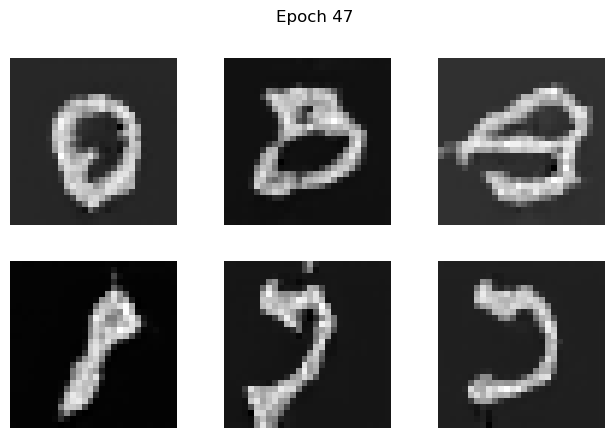

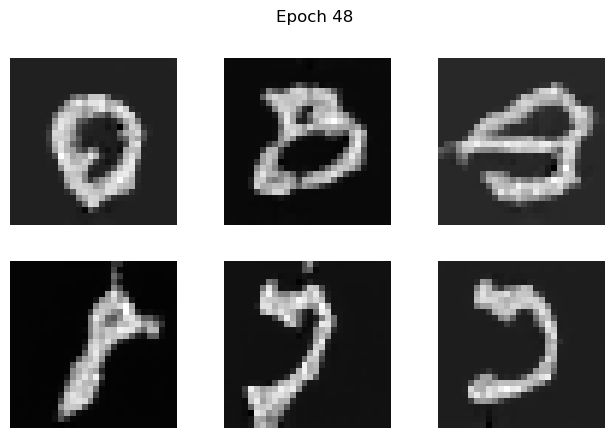

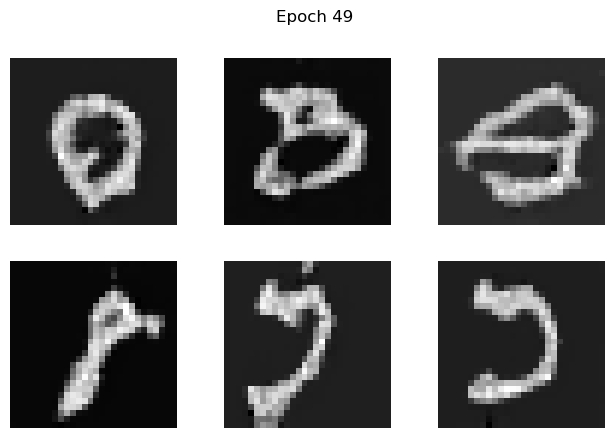

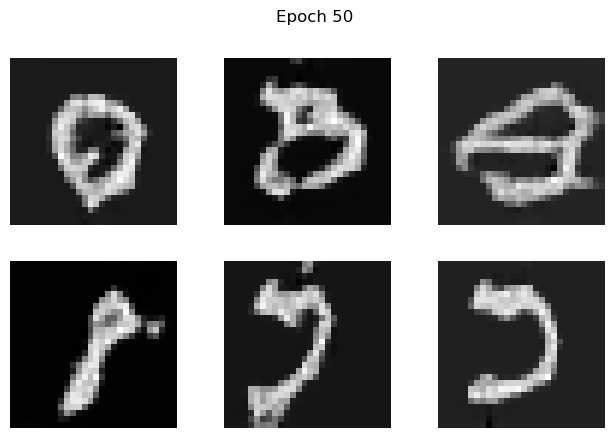

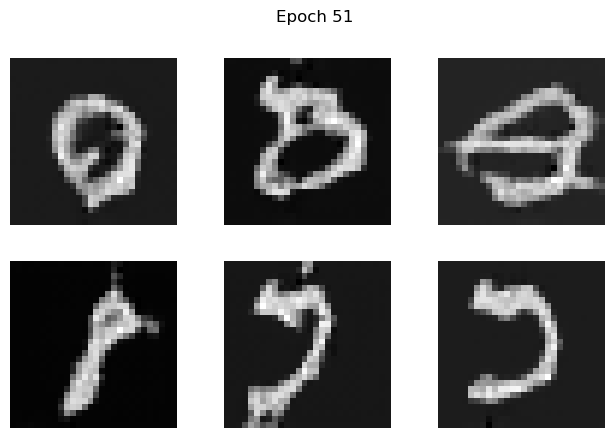

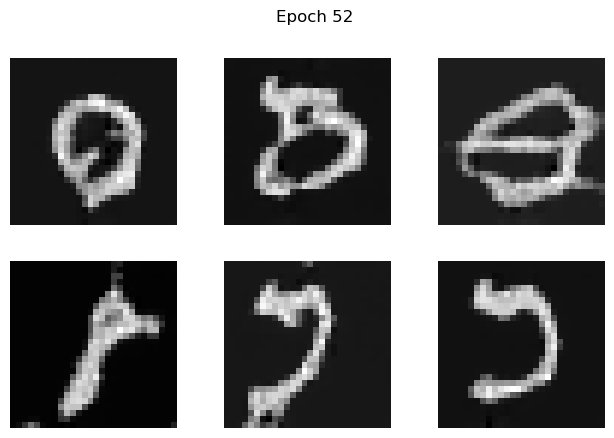

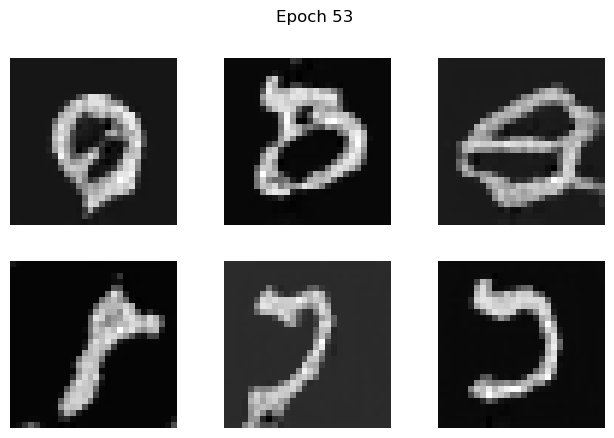

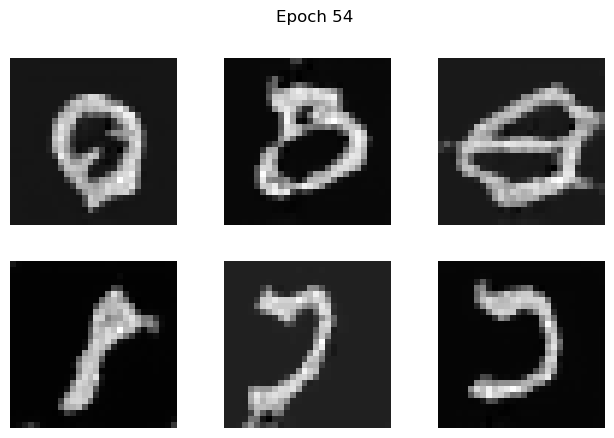

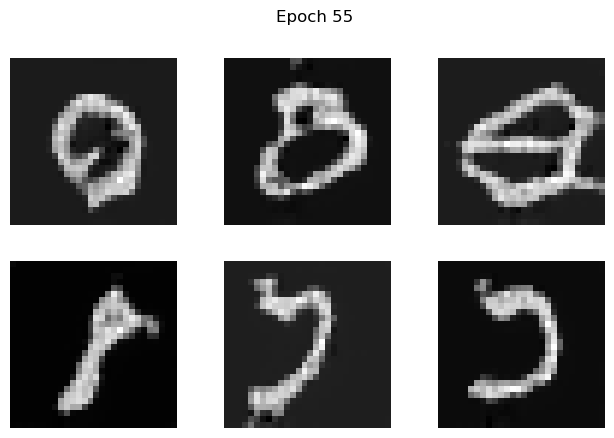

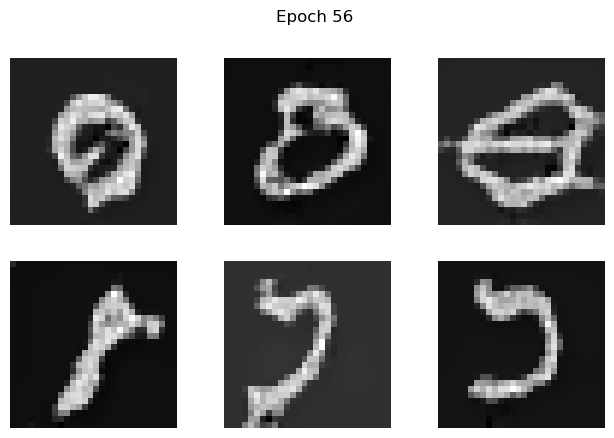

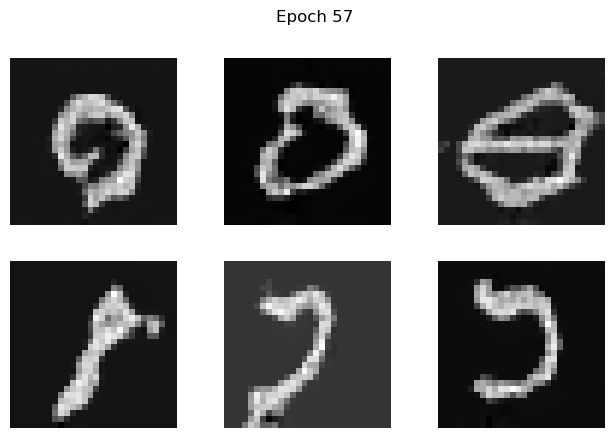

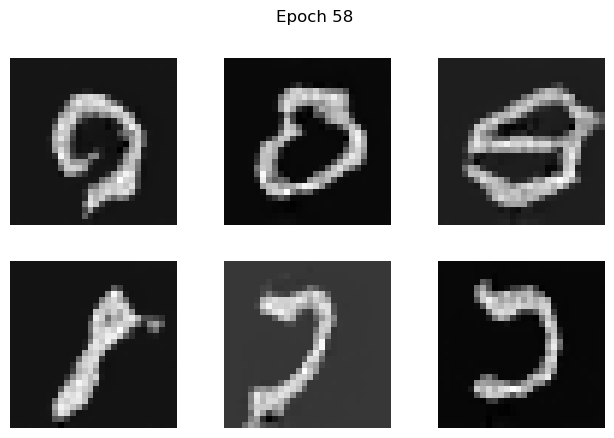

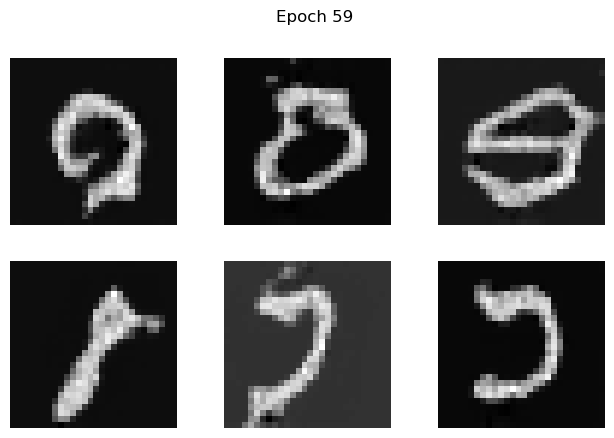

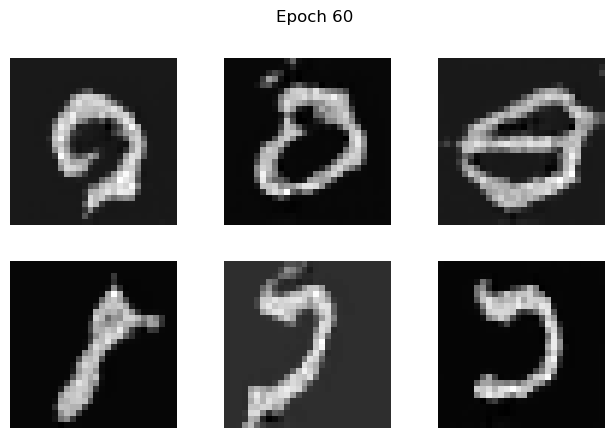

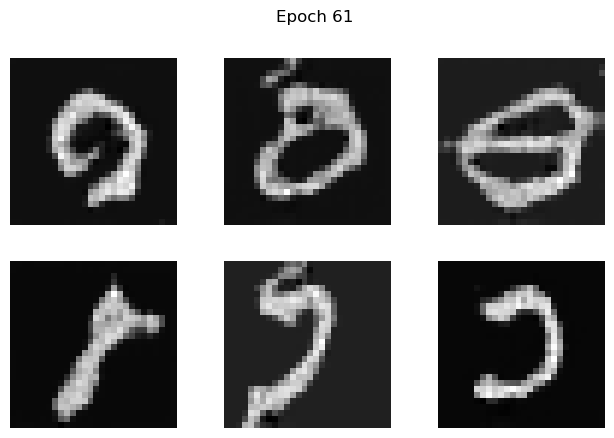

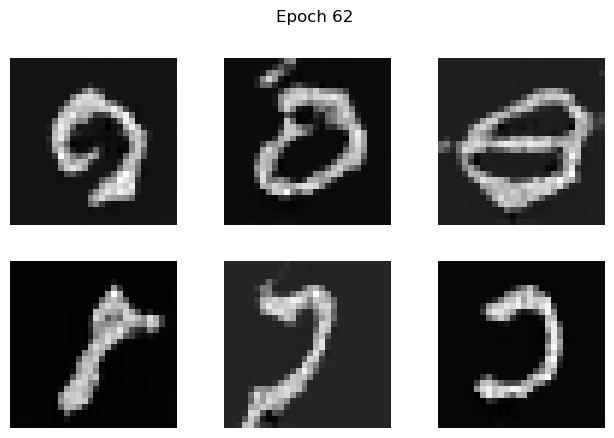

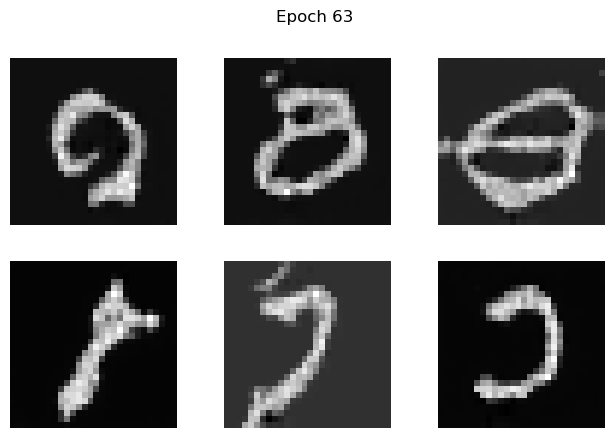

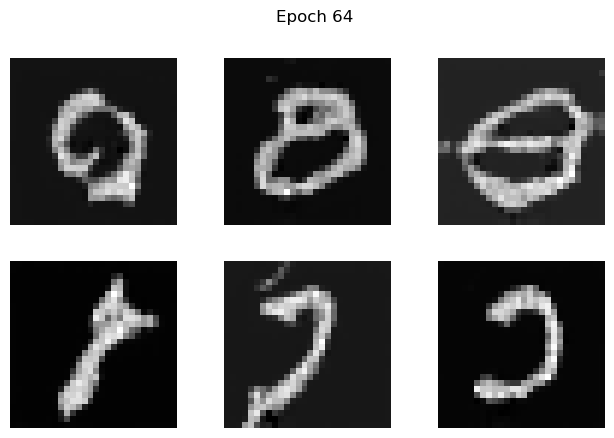

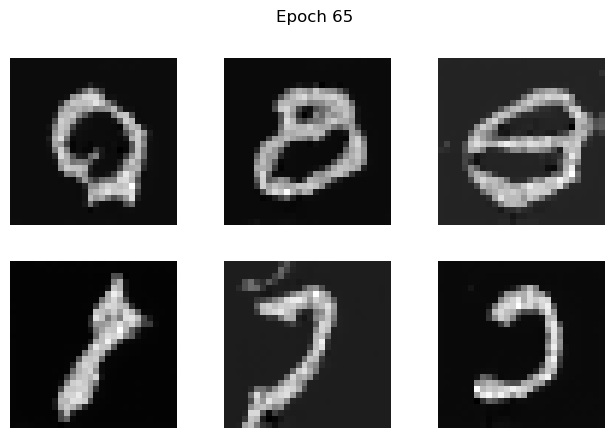

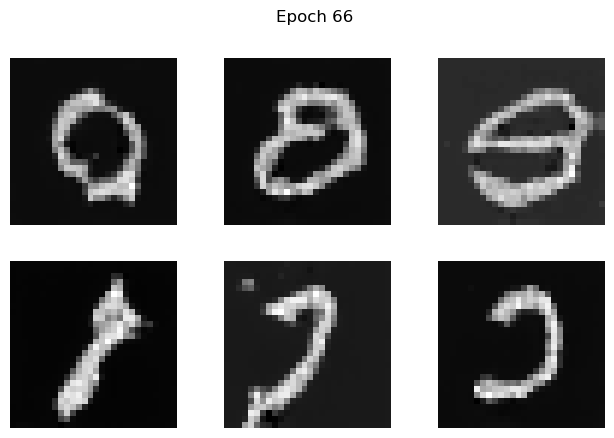

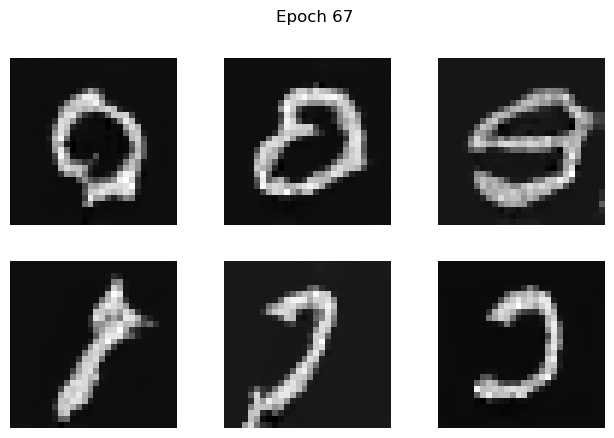

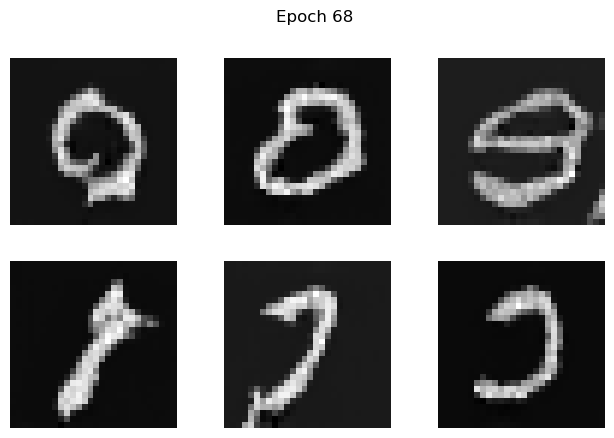

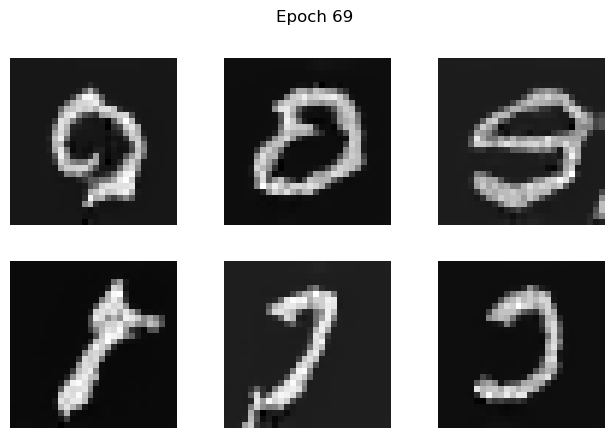

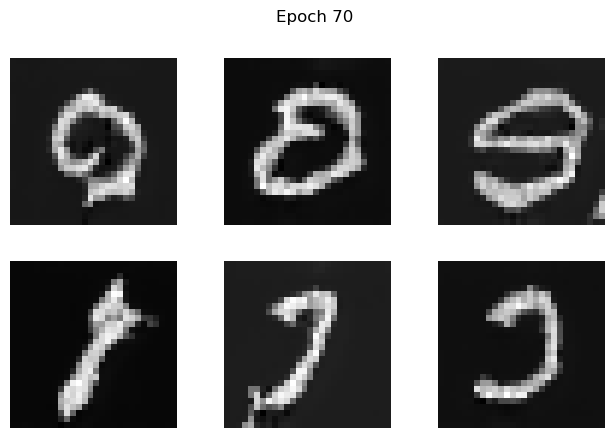

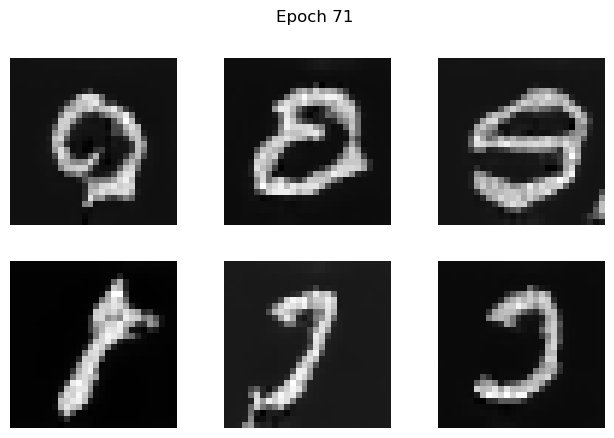

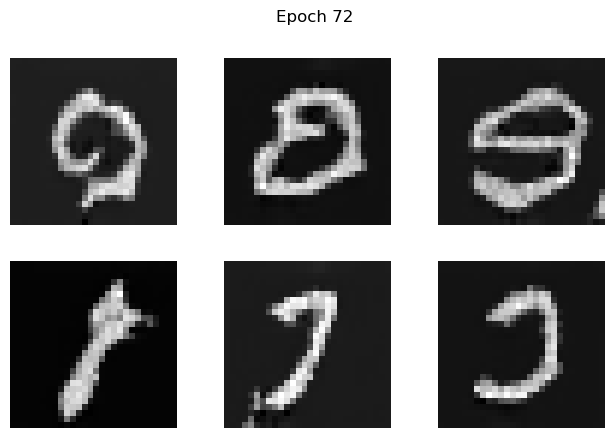

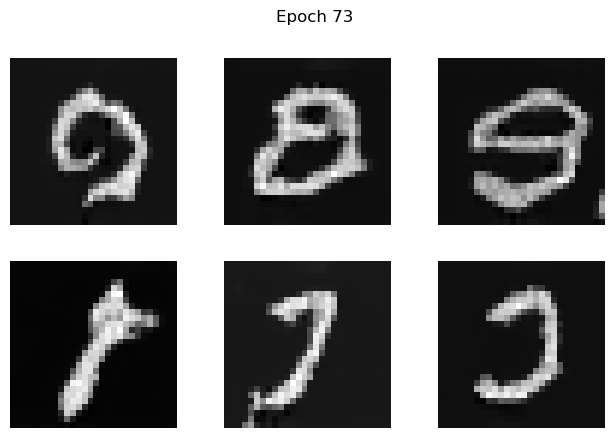

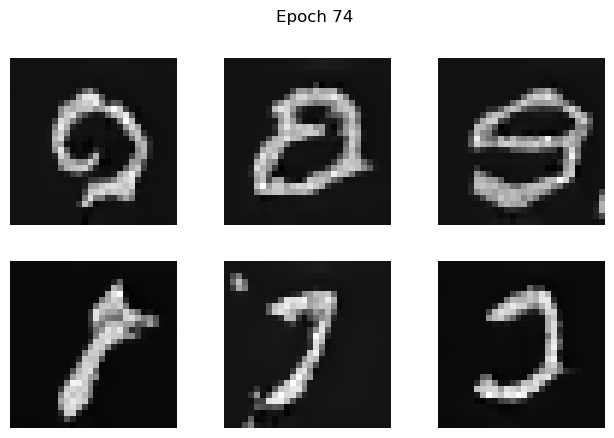

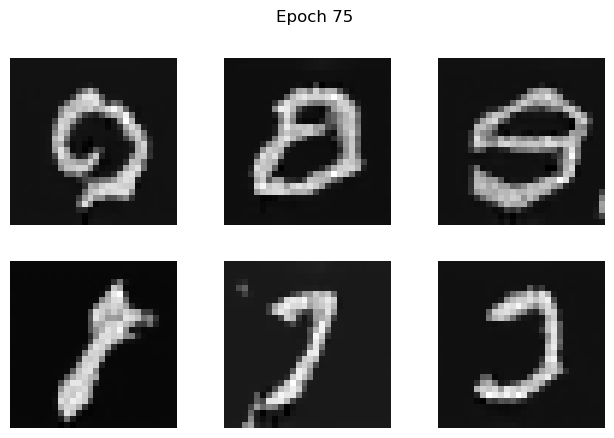

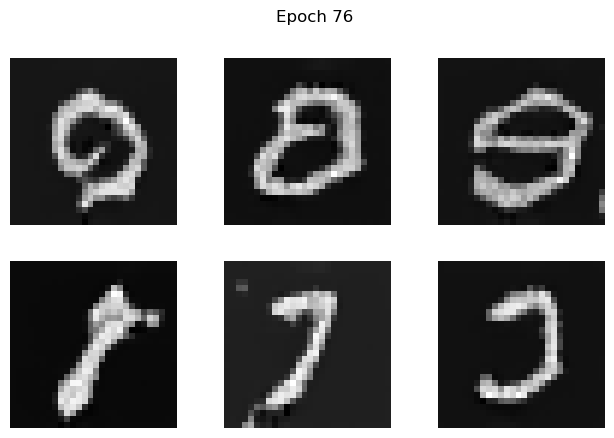

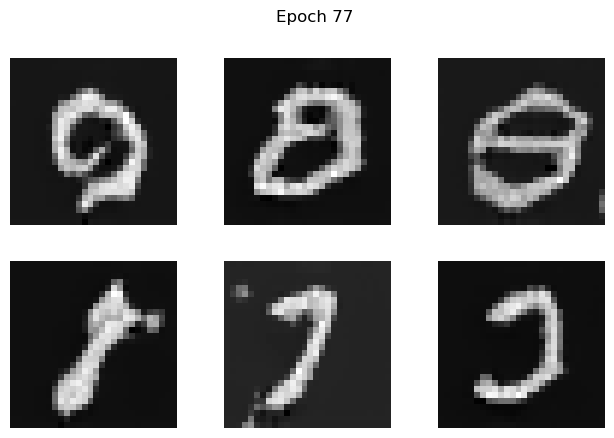

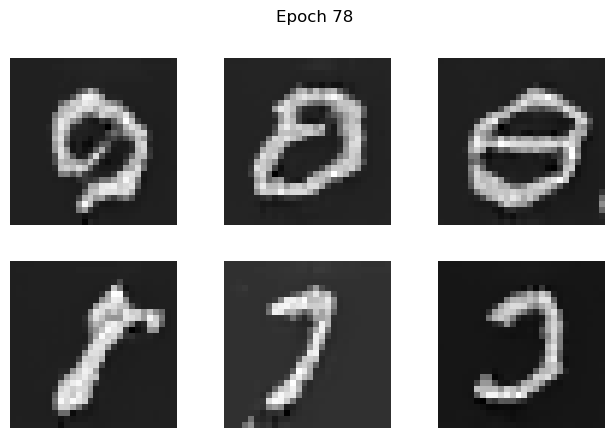

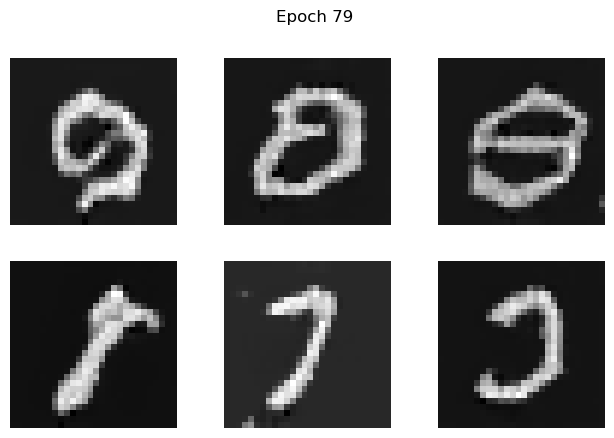

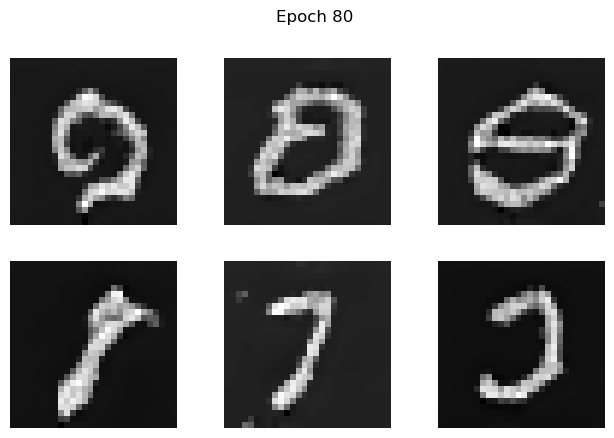

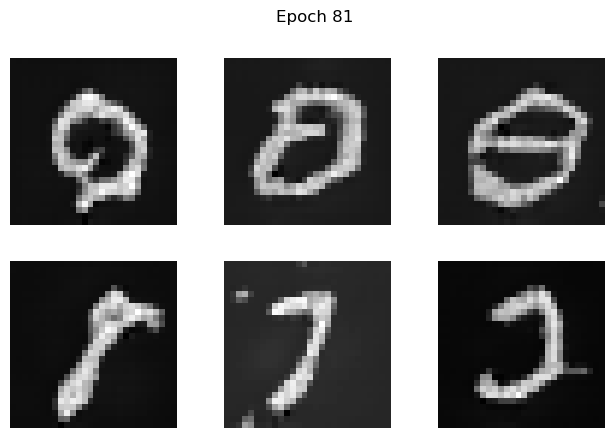

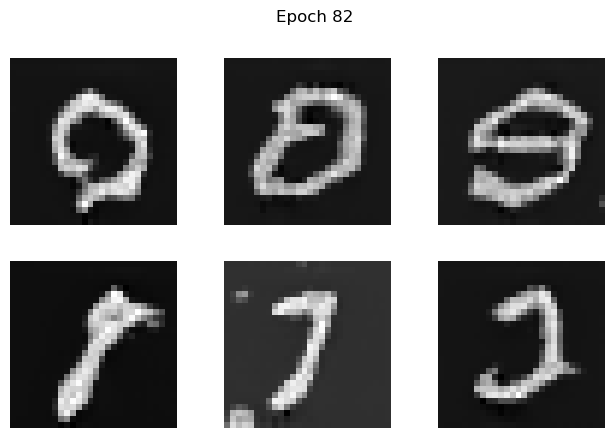

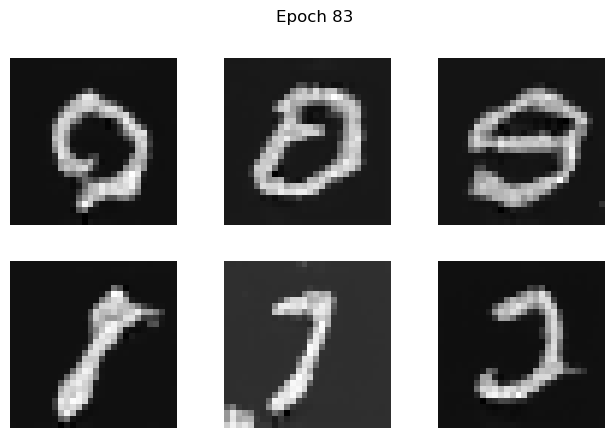

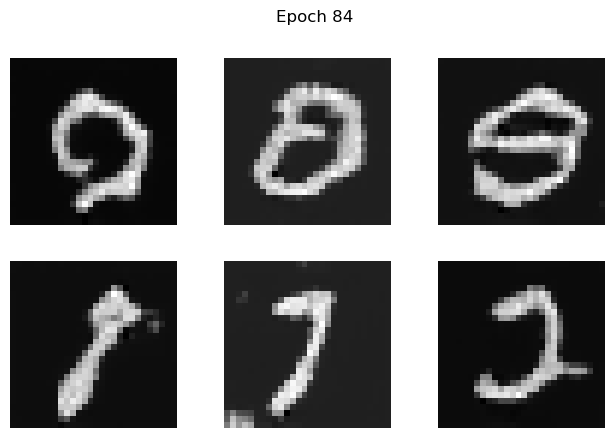

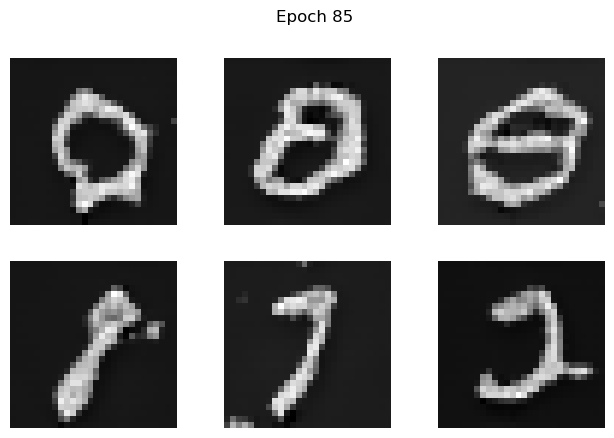

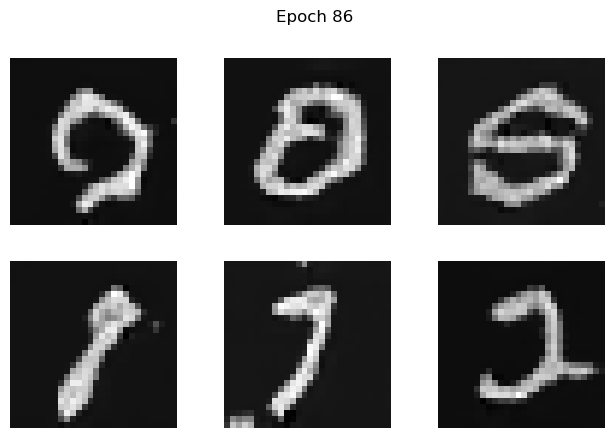

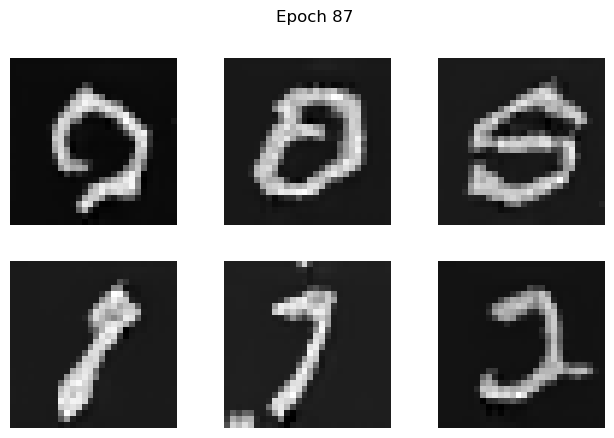

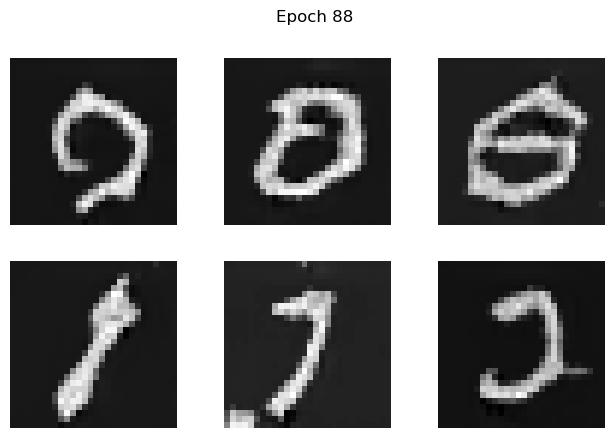

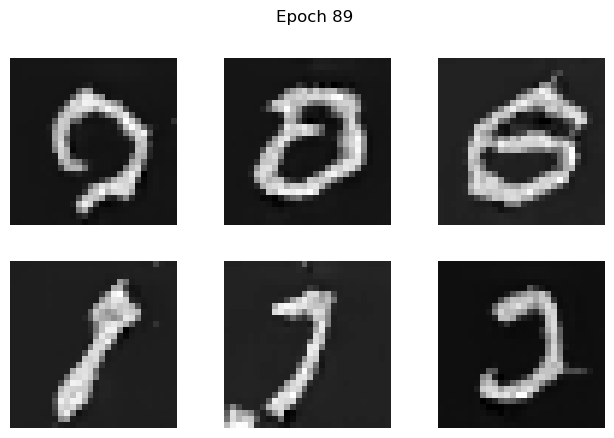

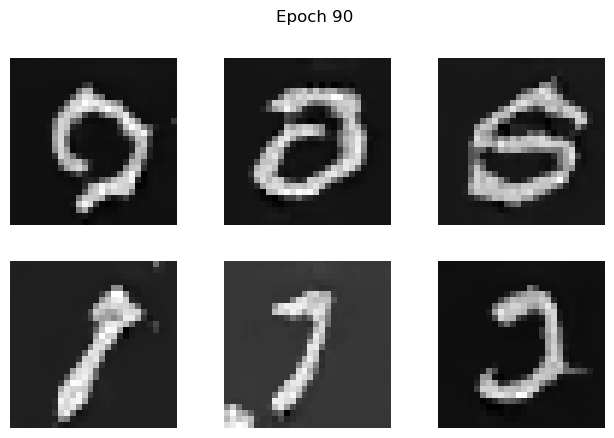

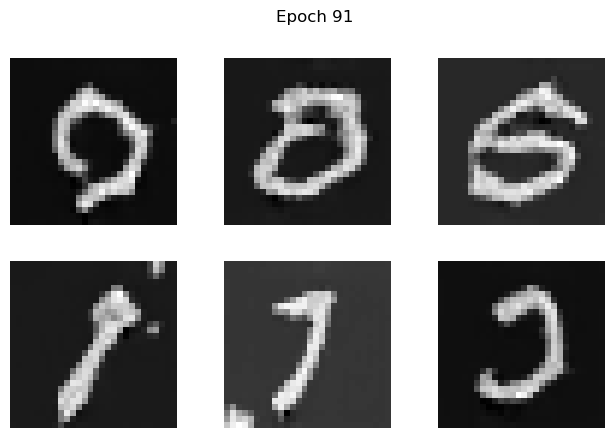

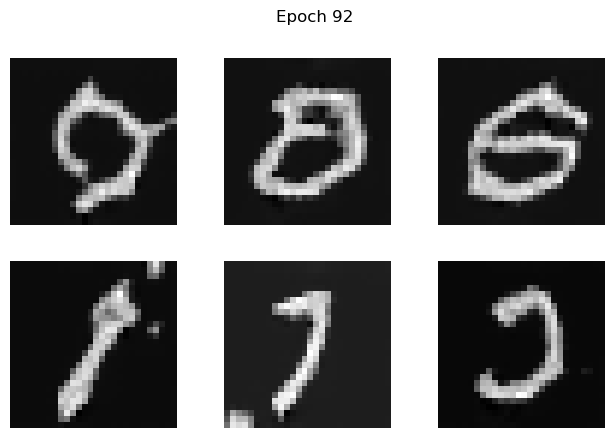

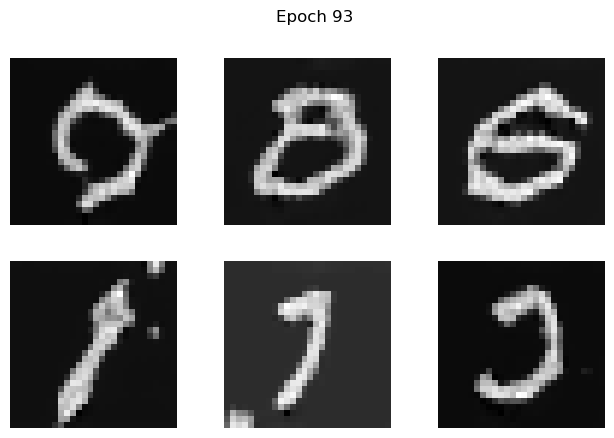

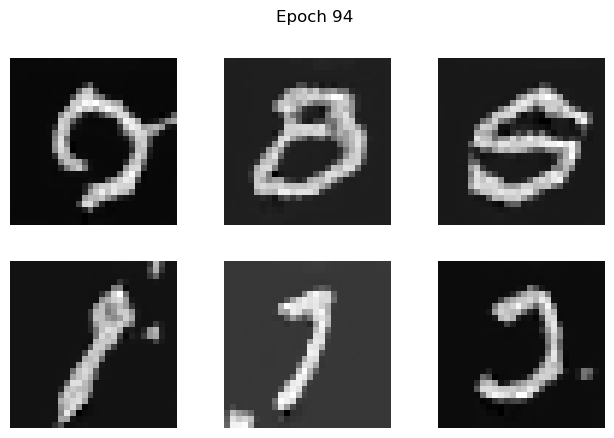

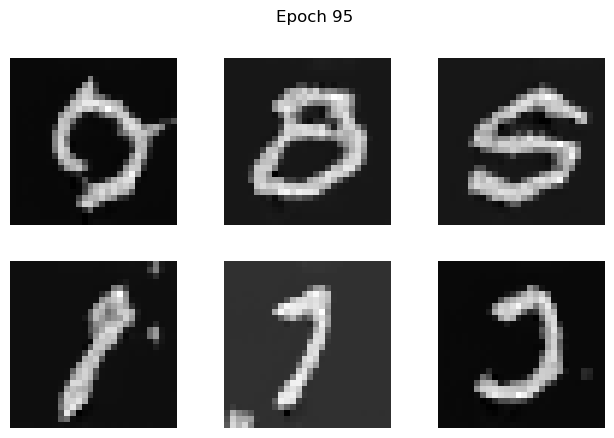

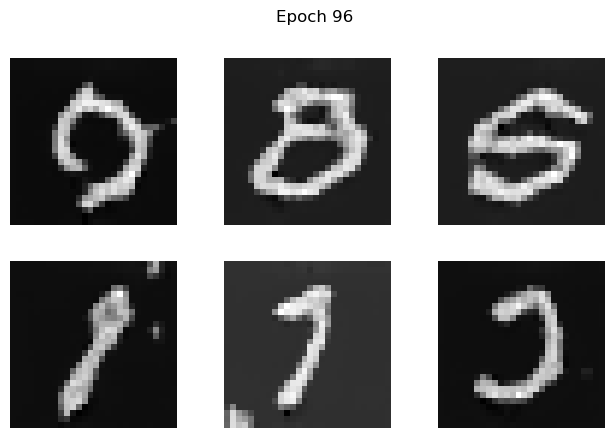

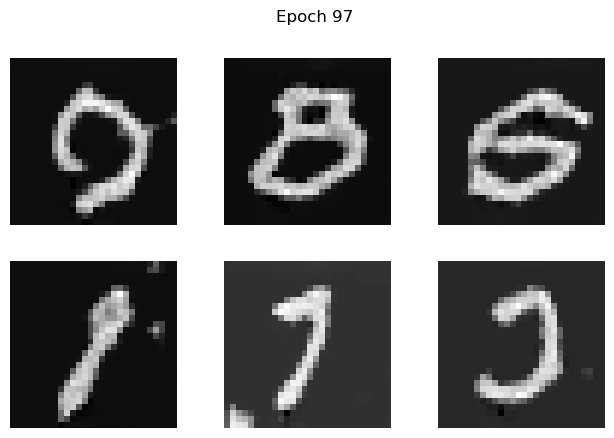

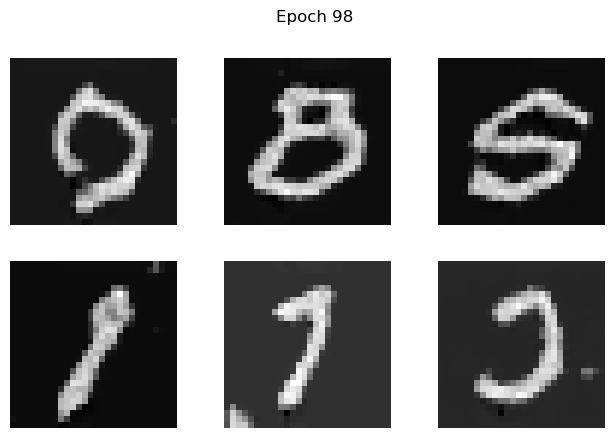

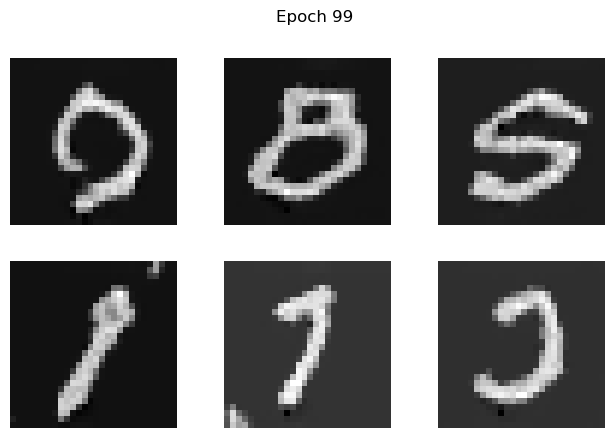

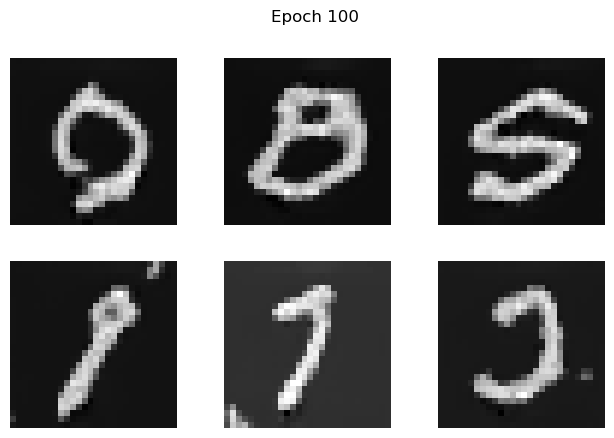

`Trainer.fit` stopped: `max_epochs=100` reached.


In [9]:
# Cargamos los datos y creamos el modelo
dm = MNISTDataModule()
model = GAN(latent_dim = 100, lr = 0.0002)

# Imprimimos la entrada inicial
model.plot_imgs(True)

# Definimos el número de épocas
epochs = 100

# Creamos los vectores vacíos en los que añadiremos las métricas
falso_loss = np.empty(epochs)
verdadero_loss = np.empty(epochs)
discriminator_loss = np.empty(epochs)
generator_loss = np.empty(epochs)

# Definimos los parametros del modelo y lo entrenamos
trainer = pl.Trainer(max_epochs = epochs, accelerator = 'gpu', devices = AVAIL_GPUS)
trainer.fit(model, dm)

# Análsis de métricas

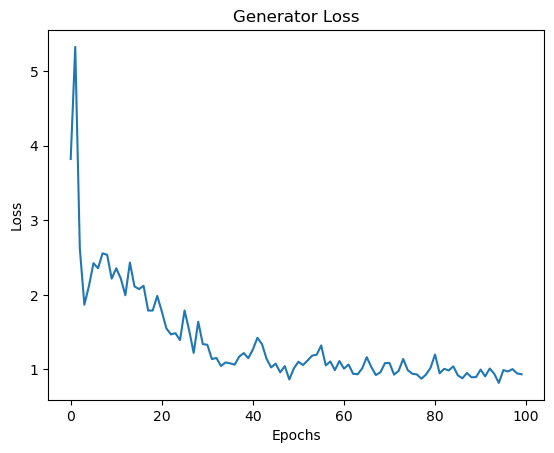

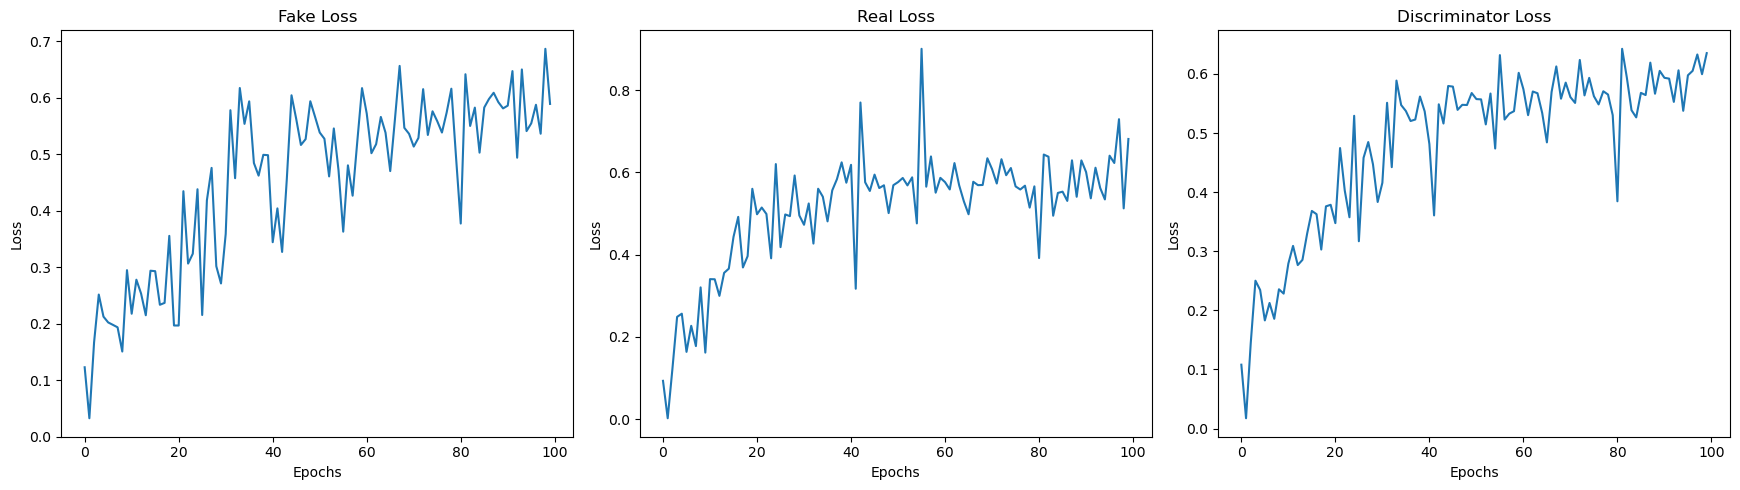

In [10]:
# Comenzamos imprimiendo la pérdida del generador
fig = plt.figure()
plt.tight_layout()
plt.title('Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(generator_loss)
plt.show()

# Y terminamos imprimiendo la pérdida del discriminador y los fake y real           
fig, axs = plt.subplots(1, 3, figsize=(17.5, 5))
axs[0].plot(falso_loss)
axs[0].set_title('Fake Loss')
axs[0].set(xlabel='Epochs', ylabel='Loss')

axs[1].plot(verdadero_loss)
axs[1].set_title('Real Loss')
axs[1].set(xlabel='Epochs', ylabel='Loss')

axs[2].plot(discriminator_loss)
axs[2].set_title('Discriminator Loss')
axs[2].set(xlabel='Epochs', ylabel='Loss')

plt.tight_layout()

# Guardamos los datos en un txt

In [11]:
# Creamos un vector x con el número de epocas desde 1
x = np.linspace(1, len(discriminator_loss), num =len(discriminator_loss))
        
# Formamos una matriz y la transponemos para que los vectores se queden como columnas
matriz = np.array([x, discriminator_loss])
matriz = matriz.transpose()
        
# Cuardamos el txt definiendo las columnas, el formato, el delimitador y evitando que aparezca el hastagh
np.savetxt("discriminator_loss.txt", matriz, header = 'Discriminator Loss', fmt='%1.10f', delimiter = ' ', comments='')

# Repetimos para la precisión
#matriz = np.array([x, entrenamiento.history['accuracy']])
#matriz = matriz.transpose()
#np.savetxt("discriminator_loss.txt", matriz, header = 'Discriminator Loss', fmt='%1.10f', delimiter = ' ', comments='')